In [2]:
import os.path, gym
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import roboschool
import pdb
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
GAMMA = .97
from functools import partial
NUM_HISTORY = N_HISTORY = 6
try:
    env.close()
except:
    pass
if 1:
    envname = "RoboschoolInvertedPendulum-v1"
    SIZE_MULT = 1
    REWARD_MULT = 1
    RANDOM_STYLE_COMPLEX = 0
    N_LAYERS = 4
else:
    envname = "RoboschoolHumanoidFlagrun-v1"
    SIZE_MULT = 4
    REWARD_MULT = 4
    RANDOM_STYLE_COMPLEX = 1
    N_LAYERS = 20
PERCENT_CHOOSE_OPTIMAL = .8
env = gym.make(envname)
N_OBS, N_ACT = [v.shape[0] for v in [env.observation_space, env.action_space]]
N_STATE = (N_OBS + N_ACT) * 2
REWARD_IN_STATE = 0
if REWARD_IN_STATE:
    N_STATE += 2
INPUT_UNITS = N_STATE * NUM_HISTORY
STATE_DECAY = .8
TESTING_GRAD_NORMS = 1
ADV_ENABLED = 0
STORED_MODELS = {}
FCNS = {'np':{
    'concat':np.concatenate,
    'reshape':np.reshape,
    'expand':np.expand_dims
},'tf':{
    'concat':tf.concat,
    'reshape':tf.reshape,
    'expand':tf.expand_dims
}}

In [9]:
x = np.arange(-100, 100, .01)

y = np.log(np.abs(x)+1) * np.sign(x)

plt.plot(x, y)

In [48]:

def apply_clipped_optimizer(opt_fcn,
                            loss,
                            clip_norm=.1,
                            clip_single=.03,
                            clip_global_norm=False,
                            var_list=None):
    if var_list is None:
        gvs = opt_fcn.compute_gradients(loss)
    else:
        gvs = opt_fcn.compute_gradients(loss, var_list = var_list)
        

    if clip_global_norm:
        gs, vs = zip(*[(g, v) for g, v in gvs if g is not None])
        capped_gs, grad_norm_total = tf.clip_by_global_norm([g for g in gs],clip_norm)
        capped_gvs = list(zip(capped_gs, vs))
    else:
        grad_norm_total = tf.sqrt(
                tf.reduce_sum([
                        tf.reduce_sum(tf.square(grad)) for grad, var in gvs
                        if grad is not None
                ]))
        capped_gvs = [(tf.clip_by_value(grad, -1 * clip_single, clip_single), var)
                                    for grad, var in gvs if grad is not None]
        capped_gvs = [(tf.clip_by_norm(grad, clip_norm), var)
                                    for grad, var in capped_gvs if grad is not None]

    optimizer = opt_fcn.apply_gradients(capped_gvs)

    return optimizer, grad_norm_total

class MLP:
    def __init__(self,
                x, lshapes, output_units, namebase, squeeze = True,
                lshapes_drop = None, drop_rate = .2, reuse = False):
        self.namebase = namebase
        self.reuse = reuse
        self.lidx = 0
        name_fcn = self.get_name
        h = [tf.nn.leaky_relu(tf.layers.dense(
            x, lshapes[0], name=self.get_name(), reuse = self.reuse))]
        h2 = h[-1]
        for size in lshapes:
            h.append(tf.nn.leaky_relu(h[-1] + tf.layers.dense(
                h2, size, name=name_fcn(), reuse = self.reuse)))
            h2 = tf.concat((x, h[-1]), -1)
        if lshapes_drop is None:
            hout = tf.concat((h[len(h)//2:]), -1)
            output = tf.layers.dense(
                hout, output_units, name=name_fcn(), reuse = self.reuse)
            if output_units == 1 and squeeze:
                output = tf.squeeze(output, -1)
            self.raw_output = output
            self.output = leaky_tanh(self.raw_output)
        else:
            drop_outs = []
            x_drop = tf.concat((h[len(h)//2:]), -1)
            name_fcn = self.get_name_drop
            self.lidx_drop = 0
            for drop_idx, drop_try in enumerate(lshapes_drop):
                h_drop = [x_drop]
                for lsize in lshapes_drop:
                    new_layer = tf.nn.dropout(tf.nn.leaky_relu(tf.layers.dense(
                        h_drop[-1], size, name=name_fcn(), reuse = self.reuse)), keep_prob = 1-drop_rate)
                    h_drop.append(new_layer)
                output = tf.layers.dense(h_drop[-1], output_units)
                if output_units == 1 and squeeze:
                    output = tf.squeeze(output, -1)
                output = leaky_tanh(output)
                drop_outs.append(output)
                self.reuse = True
                self.lidx_drop = 0
            self.output = tf.stack(drop_outs, -1)
            self.output_mean, self.variance = tf.nn.moments(self.output, -1)
    def get_name(self):
        self.lidx = self.lidx + 1
        return self.namebase + str(self.lidx)
    def get_name_drop(self):
        self.lidx_drop = self.lidx_drop + 1
        return self.namebase + '_drop_' + str(self.lidx_drop)

In [49]:


def make_state(state, action, style = 'np'):
    together = FCNS[style]['concat']((state, action), -1)
    if style == 'tf':
        return together
#         expanded = FCNS[style]['expand'](
#             together, 1)
    else:
        expanded = FCNS[style]['expand'](
            together, 0)
    return expanded
    return FCNS[style]['reshape'](
        together, (state.shape[0], -1, state.shape[-1] + action.shape[-1]))
        
    

def accumulate_state(state, action, old_state, statedecay, style = 'np'):
    new_state = make_state(state, action, style)
    new_state_len = new_state.shape[-1]
    if style == 'tf':
        vel = new_state - old_state[:,:,0,:new_state_len]
    else:
        vel = new_state - old_state[0,:new_state_len]
    new_state = FCNS[style]['concat']((new_state, vel), -1)
    if style == 'tf':
        return FCNS[style]['concat']((tf.expand_dims(new_state, 2), old_state[:,:,:-1,:]*statedecay), 2)
    return FCNS[style]['concat']((new_state, old_state[:-1,:]*statedecay), 0)

def leaky_tanh(x):
    return tf.log(tf.abs(x)+1) * tf.sign(x)
    #return tf.nn.tanh(x*30)/10 + tf.nn.tanh(x*2)/2 + tf.nn.tanh(x/20) * 2 + x * 1e-3

In [ ]:


class PolicyLearner(object):
    def __init__(self, ob_space, ac_space, take_weights_here=None, 
                 lshapes = [64 * SIZE_MULT] * N_LAYERS, config = None, 
                 lshapes_small = [32 * SIZE_MULT] * N_LAYERS,
                 lshapes_smaller = [32 * SIZE_MULT] * N_LAYERS,
                 lshapes_drop = [16 * SIZE_MULT] * 3):
        self.sess = tf.InteractiveSession(config=config)
        self.obs_raw = tf.placeholder(tf.float32, (None, None, NUM_HISTORY, N_STATE))
        self.returns = tf.placeholder(tf.float32, (None, None))
        self.returnsdecayed = tf.placeholder(tf.float32, (None, None))
        self.mask = tf.placeholder(tf.float32, (None, None))
        self.lr = tf.placeholder_with_default(1e-3, (None))
        self.statesraw = tf.placeholder(tf.float32, (None, None, N_OBS))
        self.is_train = tf.placeholder_with_default(True, (None))
        self.is_exploit = tf.placeholder(tf.float32, (None))
        self.is_exploit2d = tf.expand_dims(self.is_exploit, -1)
        self.is_exploit3d = tf.expand_dims(self.is_exploit2d, -1)
        self.statesraw_expanded = tf.expand_dims(self.statesraw, -1)
        self.obs_raw_expanded = tf.expand_dims(self.obs_raw, -1)
        self.obs = tf.reshape(
            self.obs_raw, (
                tf.shape(self.obs_raw)[0], tf.shape(self.obs_raw)[1], N_STATE * NUM_HISTORY))
        
        self.actor = MLP(
            self.obs, lshapes, N_ACT, 'a_', squeeze = False)
        self.actions = self.actor.output
        self.state_value_estimator = MLP(
            self.obs, lshapes_smaller, 1, 'v_')
        self.state_value_estimate = self.state_value_estimator.output
        self.advantage = ((
            self.state_value_estimate * GAMMA + self.returns[:,:-1]) -
            self.state_value_estimate)
        
        self.critic_input = tf.concat((self.obs, self.actions), -1)
        
        self.advantage_estimator = MLP(
            self.critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop)
        self.advantage_estimate = self.advantage_estimator.output_mean
        self.model_estimator = MLP(
            self.critic_input, lshapes, N_OBS, 'm_', lshapes_drop = lshapes_drop)
        self.model_estimate = self.model_estimator.output_mean
        self.future_obs_raw = accumulate_state(
            self.model_estimate, self.actions, self.obs_raw, STATE_DECAY, style = 'tf')
        
        self.future_obs = tf.reshape(self.future_obs_raw, 
            (tf.shape(self.future_obs_raw)[0],tf.shape(self.future_obs_raw)[1], N_STATE * NUM_HISTORY))
        
        self.future_value = MLP(
            self.future_obs, lshapes_smaller, 1, 'v_', reuse = True)
        

        self.future_actor = MLP(
            self.future_obs, lshapes, N_ACT, 'a_', reuse = True, squeeze = False)
        self.future_actions = self.future_actor.output
        
        self.future_critic_input = tf.concat((self.future_obs, self.future_actions), -1)
        self.future_advantage_estimator = MLP(
            self.future_critic_input, lshapes_small, 1, 'c_', lshapes_drop = lshapes_drop, reuse = True)
        
        if len(self.future_actions.shape) == 2:
            self.future_actions = tf.expand_dims(self.future_actions, -1)
        
        self.t_vars = tf.trainable_variables()
        self.a_vars = [var for var in self.t_vars if 'a_' in var.name]
        self.v_vars = [var for var in self.t_vars if 'v_' in var.name]
        self.c_vars = [var for var in self.t_vars if 'c_' in var.name]
        self.m_vars = [var for var in self.t_vars if 'm_' in var.name]
        
        self.creg, self.areg, self.vreg, self.mreg = [
            tf.reduce_mean([tf.reduce_mean(tf.square(v)) for v in optvars]) * 1e0
            for optvars in 
            [self.c_vars, self.a_vars, self.v_vars, self.m_vars]]
        self.maskexpanded = tf.expand_dims(self.mask, -1)
        
        
        self.model_state_estimate = self.model_estimator.output_mean
        
        
        self.v_loss_raw = tf.reduce_mean(tf.square(
            self.returnsdecayed - self.state_value_estimate) * self.mask * self.is_exploit2d)
        self.v_loss =  self.v_loss_raw + self.vreg
        
        self.m_loss_raw = tf.reduce_mean(tf.square(
            self.model_estimator.output[:,:-1] - self.statesraw_expanded[:,1:]
        ) * self.maskexpanded[:,:-1]) * 100
        self.m_loss = self.m_loss_raw + self.mreg
        
        self.c_loss_raw = tf.reduce_mean(tf.square(
            self.advantage_estimate[:,:-1] - self.advantage) * self.mask[:,:-1])
        self.c_loss =  self.c_loss_raw + self.creg
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) + tf.reduce_sum(
            self.future_actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1) 
        
        
        self.actionmean = tf.reduce_sum(
            self.actions * self.maskexpanded, 1) / tf.reduce_sum(
            self.maskexpanded, 1)
        self.actdiffsquared = tf.square(
            self.actions - tf.expand_dims(self.actionmean, 1))
        self.actvar = tf.reduce_sum(
            self.actdiffsquared * self.maskexpanded, 1)/ tf.reduce_sum(
            self.maskexpanded, 1)
        self.actstd = self.actvar
        self.actstdpenalty = -tf.reduce_mean(tf.log(self.actstd + .00001) + tf.log(1.00001 - self.actstd)) * .001
        
        self.aregmeanbyaction = tf.reduce_mean(
            tf.square(self.actionmean)) * .01
        self.a_mse = tf.reduce_mean(tf.square(
            self.actions + self.future_actions) * self.maskexpanded) * 1e-2 + tf.reduce_mean(
            tf.square(self.actor.raw_output + self.future_actor.raw_output) * self.maskexpanded) * 1e-4
        self.aregtotal = self.areg + self.aregmeanbyaction + self.actstdpenalty + self.a_mse
        
        self.frac_not_masked = tf.reduce_mean(self.mask)
        
        self.a_loss_critic = -tf.reduce_mean(
            self.advantage_estimator.output_mean * self.mask)/self.frac_not_masked * 3
        self.a_loss_model = -tf.reduce_mean(
            self.future_value.output_mean * self.mask)/self.frac_not_masked * 8
        self.a_loss_secondaction = -tf.reduce_mean(
            self.future_advantage_estimator.output_mean * self.mask)/self.frac_not_masked * 20
        self.a_loss_raw = self.a_loss_critic + self.a_loss_model + \
            self.a_loss_secondaction
        
        self.a_loss = self.a_loss_raw + self.aregtotal
        
        self.grad_v = tf.square(tf.gradients(
            self.state_value_estimator.output * self.mask, self.obs)[0])
        self.grad_m = tf.square(tf.gradients(
            self.model_estimator.output * self.maskexpanded, self.critic_input)[0])
        self.grad_c = tf.square(tf.gradients(
            self.advantage_estimator.output * self.mask, self.critic_input)[0])
        
        self.grad_norm_m = tf.reduce_mean(self.grad_m) * 1e-2
        self.grad_norm_v = tf.reduce_mean(self.grad_v) * 1e-2
        self.grad_norm_c = tf.reduce_mean(self.grad_c) * 1e-1
    
        slopes = tf.reduce_sum(tf.square(self.grad_c), reduction_indices=[2])
        self.grad_c_1 = tf.reduce_mean(self.mask * (slopes - .1) ** 2) * 1e-1
        slopes = tf.reduce_sum(tf.square(self.grad_m), reduction_indices=[2])
        self.grad_m_1 = tf.reduce_mean(self.mask * (slopes - .1) ** 2) * 1e-3
       
        self.a_loss_minimize = self.a_loss
        self.c_loss_minimize = self.c_loss + self.grad_norm_c + self.grad_c_1
        self.v_loss_minimize = self.v_loss + self.grad_norm_v
        self.m_loss_minimize = self.m_loss + self.grad_norm_m + self.grad_m_1
        
        self.critic_opt = tf.train.AdamOptimizer(self.lr/3, beta1= .8)
        self.value_opt = tf.train.AdamOptimizer(self.lr/3, beta1= .8)
        self.actor_opt = tf.train.AdamOptimizer(self.lr, beta1= .8)
        self.model_opt = tf.train.AdamOptimizer(self.lr/3, beta1= .8)
        
        def get_grad_norm(optimizer, loss):
            gvs = optimizer.compute_gradients(loss)
            grad_norm = tf.reduce_mean(
                [tf.reduce_mean(tf.square(grad)) for
                 grad, var in gvs if grad is not None])
            return grad_norm
        
        if TESTING_GRAD_NORMS:
            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]
        
        self.copt, self.c_norm = apply_clipped_optimizer(
            self.critic_opt, self.c_loss_minimize, var_list = self.c_vars)
        self.vopt, self.v_norm = apply_clipped_optimizer(
            self.value_opt, self.v_loss_minimize, var_list = self.v_vars)
        self.aopt, self.a_norm = apply_clipped_optimizer(
            self.actor_opt, self.a_loss_minimize, var_list = self.a_vars)
        self.mopt, self.m_norm = apply_clipped_optimizer(
            self.model_opt, self.m_loss_minimize, var_list = self.m_vars)

    def a_name(self):
        self.a_idx += 1
        return 'a_' + str(self.a_idx)
    def c_name(self):
        self.c_idx += 1
        return 'c_' + str(self.c_idx)
    def v_name(self):
        self.v_idx += 1
        return 'v_' + str(self.v_idx)
    def m_name(self):
        self.m_idx += 1
        return 'm_' + str(self.m_idx)
    
    def load_weights(self):
        feed_dict = {}
        for (var, w), ph in zip(
            self.assigns, self.weight_assignment_placeholders):
            feed_dict[ph] = w
        self.sess.run(self.weight_assignment_nodes, feed_dict=feed_dict)

    def act(self, obs):
        # Because we need batch dimension, 
        # data[None] changes shape from [A] to [1,A]
        a = self.sess.run(
            self.actions, feed_dict={
                self.obs_raw:np.reshape(obs, (1, 1, N_HISTORY, N_STATE)),
                self.is_train:False
            })
        return a[0][0]  # return first in batch



config = tf.ConfigProto(
    inter_op_parallelism_threads=0,
    intra_op_parallelism_threads=0,
    device_count = { "GPU": 0 } )
tf.reset_default_graph()

pi = PolicyLearner(env.observation_space, env.action_space, config = config)

sess = pi.sess
self = pi
sess.run(tf.global_variables_initializer())
#trainer = ZooPolicyTensorflow(
# "mymodel1", env.observation_space, env.action_space)
saver = tf.train.Saver()

/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [22]:
# env.close()


# env = gym.make(envname)

In [6]:

#         self.advantage = ((
#             self.stateraw_value_estimate[:,1:] * GAMMA + self.returns) -
#             self.state_value_estimate[:,:-1])

In [7]:

ah, sh, shraw, rh, rdecayedh, maskh = [
    np.zeros((0, 0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
globalframes = []
localframes = []
ep = 0
trained = 0
ongoing = 0
printfreq = 10
obj_fname = envname + str(PERCENT_CHOOSE_OPTIMAL) + 'saveobjs_unguided.pkl'
tffile = "tmp/" + envname + str(PERCENT_CHOOSE_OPTIMAL) + "unguided_trained.ckpt"
import pickle

In [8]:
ongoing = 0
sess.run(tf.global_variables_initializer())

In [9]:
if ongoing:
    
    save_path = saver.save(sess, tffile)
    print('saved at epoch', ep)
    with open(obj_fname,"wb") as f:
        pickle.dump(
            [ah, sh, rh, rdecayedh, maskh, ep, globalframes
            ], f)
    trained = 1

In [10]:
trained = 0

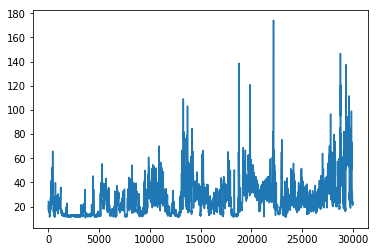

a grad norms [1202.6504, 1207.9707, 12.79345, 69.73198, 1411.4539, 3.6270896e-07, 0.00082928105, 1.9883303e-06]
aloss nan closs 7.1132565 vloss 80.650826
v grad norms [0.7604496, 1.5160275, 5.9145233e-08, 0.27327573]
c grad norms [0.46858004, 1.3931177, 1.1543572e-07, 0.003597704, 0.4054216]
m grad norms [1204960200000000.0, 6.5174203, 5.2417064e-08, 0.041408863, 1204960200000000.0]
 ep,  30010  avg frames 24.5
abs action (1,) 2.5780978202819824
max reward 2.0
a grad norms [1216.1263, 1224.9061, 13.257828, 78.34079, 1416.273, 3.590916e-07, 0.000512885, 7.045837e-06]
aloss nan closs 7.663215 vloss 96.927704
v grad norms [0.19750589, 0.29283702, 5.8232615e-08, 0.31457296]
c grad norms [20.89869, 1.5141119, 1.154383e-07, 0.009485302, 45.769154]
m grad norms [123488590000000.0, 7.8915157, 5.2414247e-08, 0.17828535, 123488540000000.0]
 ep,  30020  avg frames 25.75
abs action (1,) 0.4884905899317661
max reward 2.0
a grad norms [1337.9327, 1326.9376, 12.307495, 209.518, 1452.0339, 3.5655478e-

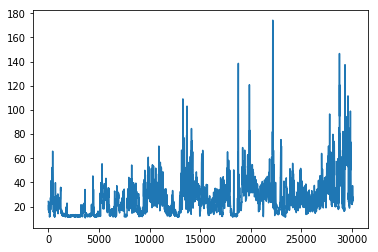

a grad norms [1361.1049, 1364.1239, 13.6153, 73.98233, 1603.2186, 3.401149e-07, 0.00023617735, 2.3987207e-07]
aloss nan closs 6.782566 vloss 77.98056
v grad norms [0.29879358, 0.29337525, 5.672337e-08, 0.19056207]
c grad norms [0.37945428, 1.2393322, 1.2079877e-07, 0.0040668664, 0.36485842]
m grad norms [2380748400000000.0, 3.2291412, 5.3038207e-08, 0.07472027, 2380748400000000.0]
 ep,  30110  avg frames 22.05
abs action (1,) 2.5795884132385254
max reward 2.0
a grad norms [1364.3651, 1370.2399, 14.325203, 92.30121, 1586.3453, 3.3844887e-07, 0.00089404284, 1.0762845e-05]
aloss nan closs 5.7348185 vloss 79.90612
v grad norms [9.953116, 8.1013975, 5.7699165e-08, 0.16543615]
c grad norms [9.636585, 1.0026869, 1.2175421e-07, 0.0059754425, 23.353197]
m grad norms [4353381300000000.0, 3.8226688, 5.301062e-08, 0.14926545, 4353380700000000.0]
 ep,  30120  avg frames 21.25
abs action (1,) 2.6032419204711914
max reward 2.0
a grad norms [1286.4904, 1291.7015, 14.800319, 68.78688, 1497.7942, 3.3749

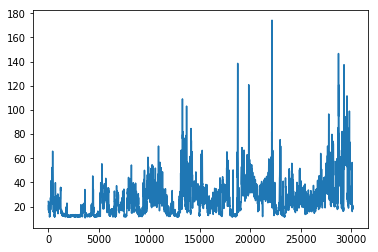

a grad norms [1194.8899, 1207.0453, 12.04229, 167.71153, 1303.2239, 3.247169e-07, 0.00019821354, 9.869517e-07]
aloss nan closs 7.2668033 vloss 99.1229
v grad norms [0.8408497, 1.4524789, 5.541753e-08, 0.23614484]
c grad norms [0.4425718, 1.381205, 1.2814745e-07, 0.004409079, 0.39982167]
m grad norms [45696920000000.0, 5.5898585, 5.314968e-08, 0.17920631, 45696930000000.0]
 ep,  30210  avg frames 19.9
abs action (1,) 2.0337915420532227
max reward 2.0
a grad norms [1273.1313, 1278.1803, 13.116612, 67.88421, 1496.9005, 3.2393757e-07, 2.777586e-05, 2.980723e-08]
aloss nan closs 5.1426535 vloss 65.1841
v grad norms [17.873795, 2.1209497, 5.4944888e-08, 22.37294]
c grad norms [0.58822834, 0.7191608, 1.2823999e-07, 0.003175795, 3.2076013]
m grad norms [73717846000000.0, 2.2562187, 5.3133547e-08, 0.4655511, 73717870000000.0]
 ep,  30220  avg frames 20.8
abs action (1,) 0.9621405601501465
max reward 2.0
a grad norms [1203.0068, 1207.5477, 13.871203, 68.43918, 1403.2909, 3.2326102e-07, 0.0005182

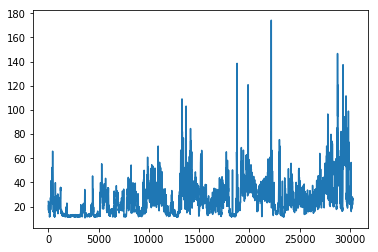

a grad norms [2206.0667, 2213.1711, 11.902875, 75.6424, 2725.6206, 3.1845153e-07, 0.00019342749, 4.2211798e-07]
aloss nan closs 4.998724 vloss 70.305954
v grad norms [355819870.0, 0.83283275, 5.1782234e-08, 355844320.0]
c grad norms [0.68276906, 1.1610465, 1.3464252e-07, 0.0019060516, 0.64678615]
m grad norms [790400140000.0, 1.389741, 5.3515432e-08, 0.0071804337, 790399600000.0]
 ep,  30310  avg frames 25.25
abs action (1,) 2.42574143409729
max reward 2.0
a grad norms [2369.662, 2371.459, 9.613287, 36.49383, 2998.434, 3.1739086e-07, 4.265632e-05, 3.0295734e-08]
aloss nan closs 5.0865645 vloss 58.183563
v grad norms [29706.344, 0.41392484, 5.171394e-08, 29584.678]
c grad norms [0.20455435, 0.56744784, 1.3525421e-07, 0.0014530648, 1.1424713]
m grad norms [533594900000.0, 1.6300534, 5.3655608e-08, 0.03606802, 533593850000.0]
 ep,  30320  avg frames 23.5
abs action (1,) 2.5169334411621094
max reward 2.0
a grad norms [2456.83, 2447.0625, 7.5044885, 229.41463, 2938.43, 3.2289938e-07, 0.0017

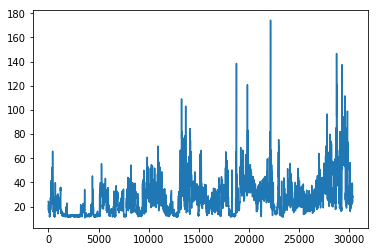

a grad norms [2330.7458, 2388.3972, 9.895766, 190.95586, 2799.2297, 3.1957083e-07, 0.00012391551, 2.353511e-07]
aloss nan closs 5.333634 vloss 63.921623
v grad norms [1.4191953, 1.209912, 4.8036867e-08, 0.0747779]
c grad norms [0.14102231, 0.6798288, 1.4150454e-07, 0.0017044801, 1.3843532]
m grad norms [51654296000.0, 1.1039492, 5.3979168e-08, 0.0070779063, 51654200000.0]
 ep,  30410  avg frames 28.1
abs action (1,) 0.9611901640892029
max reward 2.0
a grad norms [2536.1711, 2545.2349, 11.362953, 69.792755, 3181.4963, 3.1891116e-07, 6.514222e-05, 5.7321436e-09]
aloss nan closs 4.685798 vloss 31.386234
v grad norms [933.98193, 6.4150834, 4.696875e-08, 825.8296]
c grad norms [16.702856, 0.5621688, 1.4154703e-07, 0.0022635465, 32.698395]
m grad norms [144500490000.0, 0.98873633, 5.4071606e-08, 0.0037401852, 144500460000.0]
 ep,  30420  avg frames 28.45
abs action (1,) 2.488485097885132
max reward 2.0
a grad norms [2235.5312, 2252.9, 10.94736, 42.632034, 2811.8198, 3.1575567e-07, 0.00019556

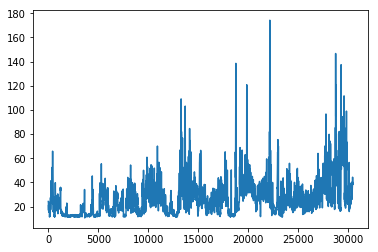

a grad norms [1295.2198, 1300.6548, 10.205375, 111.73207, 1531.5339, 3.0064666e-07, 0.00034102274, 2.3981042e-07]
aloss nan closs 4.6428847 vloss 36.93544
v grad norms [92838.336, 0.21219216, 4.4967724e-08, 92775.875]
c grad norms [0.15534934, 0.52655864, 1.4695433e-07, 0.0016877906, 1.2598358]
m grad norms [251663140000.0, 0.834227, 5.430519e-08, 0.0021714556, 251663040000.0]
 ep,  30510  avg frames 47.35
abs action (1,) 2.511263847351074
max reward 2.0
a grad norms [19791850000.0, 1167.4169, 9.706407, 87.777466, 1399.7974, 2.9815803e-07, 17.346134, 7.83497e-07]
aloss nan closs 392.73264 vloss 444.1029
v grad norms [4031.1501, 4094.403, 4.53375e-08, 1.9136192]
c grad norms [4542.797, 1950.3577, 1.4793746e-07, 0.0008459897, 3850.1003]
m grad norms [1018064300000.0, 1.747652, 5.4299225e-08, 0.04805376, 1018062400000.0]
 ep,  30520  avg frames 44.9
abs action (1,) 2.546288013458252
max reward 2.0
a grad norms [727551200.0, 1296.5226, 15.107354, 51.01047, 1516.6239, 3.0422743e-07, 0.59528

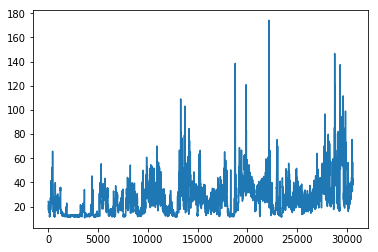

a grad norms [1310.453, 1317.7972, 11.6562395, 79.92584, 1570.8279, 3.0596559e-07, 2.2305101e-05, 8.606337e-08]
aloss nan closs 3.4609656 vloss 41.292847
v grad norms [20.49904, 19.706795, 4.6647212e-08, 0.029450037]
c grad norms [0.14462987, 0.35981464, 1.5430881e-07, 0.0006121735, 0.0929608]
m grad norms [332464420000.0, 0.6434286, 5.464038e-08, 0.0027652392, 332464230000.0]
 ep,  30610  avg frames 38.35
abs action (1,) 2.5085947513580322
max reward 2.0
a grad norms [1319.1588, 1267.2268, 12.61103, 91.660545, 1497.3949, 3.0870532e-07, 3.113652e-05, 1.399119e-08]
aloss nan closs 4.158798 vloss 59.304314
v grad norms [5.949859, 0.8135471, 4.674514e-08, 3.040371]
c grad norms [1.7487997, 0.603782, 1.5508802e-07, 0.0037741484, 5.890764]
m grad norms [325706060000.0, 1.719055, 5.4647895e-08, 0.24822575, 325706870000.0]
 ep,  30620  avg frames 37.55
abs action (1,) 2.6420693397521973
max reward 2.0
a grad norms [3026114800.0, 1406.9703, 14.405933, 63.866917, 1659.9137, 3.058257e-07, 1.2792

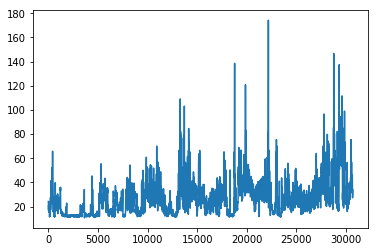

a grad norms [1523.944, 1557.0431, 13.77518, 286.15558, 1607.0281, 3.0666982e-07, 9.1414695e-05, 9.129632e-09]
aloss nan closs 3.482005 vloss 54.01111
v grad norms [2.926302, 3.7801368, 4.7216634e-08, 0.071819104]
c grad norms [0.09972521, 0.5374597, 1.6347117e-07, 0.0021091423, 0.36162582]
m grad norms [54988650000000.0, 2.5571282, 5.488595e-08, 0.08479062, 54988663000000.0]
 ep,  30710  avg frames 31.75
abs action (1,) 2.6340198516845703
max reward 2.0
a grad norms [1438.2456, 1430.7953, 12.885011, 241.00456, 1601.1792, 3.1295585e-07, 0.0003265932, 4.8883396e-07]
aloss nan closs 3.537637 vloss 49.540184
v grad norms [47215.98, 0.5840644, 4.7634092e-08, 47486.145]
c grad norms [1.0758653, 0.5462699, 1.6353499e-07, 0.002651363, 3.919256]
m grad norms [8577617500000.0, 1.0785246, 5.4962072e-08, 0.05521865, 8577617500000.0]
 ep,  30720  avg frames 35.8
abs action (1,) 2.658623218536377
max reward 2.0
a grad norms [1393.8065, 1400.3102, 12.624549, 48.144684, 1702.8345, 3.1126288e-07, 2.25

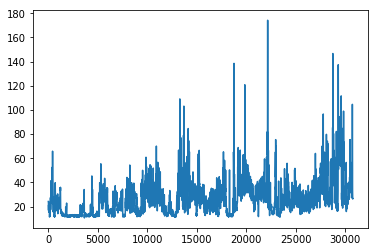

a grad norms [1041.0499, 1048.9781, 15.156301, 128.54865, 1164.9143, 3.1756414e-07, 8.78439e-06, 4.9814187e-08]
aloss nan closs 3.1787577 vloss 52.083874
v grad norms [2.6938837, 3.0306332, 4.9233265e-08, 0.13978153]
c grad norms [0.051732674, 0.48524082, 1.6598513e-07, 0.0022397116, 0.63863426]
m grad norms [817887400000.0, 2.0377216, 5.5215807e-08, 0.0066021173, 817888170000.0]
 ep,  30810  avg frames 26.45
abs action (1,) 2.6337692737579346
max reward 2.0
a grad norms [1028.025, 1037.4747, 15.573482, 91.56969, 1175.3389, 3.1611344e-07, 9.960617e-05, 3.9124117e-08]
aloss nan closs 3.084026 vloss 49.603874
v grad norms [1096.3477, 1.1693219, 4.8873783e-08, 1099.526]
c grad norms [0.094829395, 0.4634577, 1.6636575e-07, 0.0017899601, 0.24750249]
m grad norms [30267632000.0, 1.1732608, 5.524775e-08, 0.008599863, 30267357000.0]
 ep,  30820  avg frames 25.9
abs action (1,) 2.64520263671875
max reward 2.0
a grad norms [579657660.0, 1137.5282, 16.22035, 111.60238, 1288.0695, 3.2083324e-07, 0

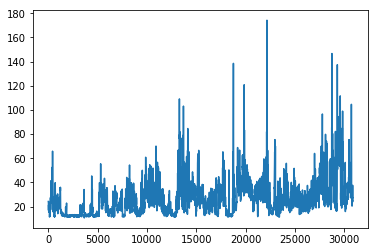

a grad norms [1205.3547, 1221.5847, 16.705385, 115.22299, 1369.4401, 3.1948318e-07, 7.7050494e-08, 1.2402374e-08]
aloss nan closs 3.2213583 vloss 45.657745
v grad norms [0.9835291, 0.814255, 4.8424784e-08, 0.075321026]
c grad norms [0.5555274, 0.41666126, 1.7376486e-07, 0.0027243663, 2.501999]
m grad norms [62503563000.0, 0.7858899, 5.5201514e-08, 0.0024306178, 62503450000.0]
 ep,  30910  avg frames 23.75
abs action (1,) 2.6532440185546875
max reward 2.0
a grad norms [1244.8488, 1245.7537, 14.31688, 116.80992, 1449.2406, 3.2376934e-07, 8.536095e-05, 5.7555656e-08]
aloss nan closs 3.7461817 vloss 51.828568
v grad norms [0.16829462, 0.44500935, 4.776553e-08, 0.10520796]
c grad norms [0.16330399, 0.5377851, 1.7463206e-07, 0.0015180722, 0.1597542]
m grad norms [16248401000.0, 1.2195829, 5.5256127e-08, 0.002073515, 16248415000.0]
 ep,  30920  avg frames 24.95
abs action (1,) 2.6668848991394043
max reward 2.0
a grad norms [1320.7806, 1331.8978, 15.812388, 135.9956, 1513.3939, 3.2560126e-07, 

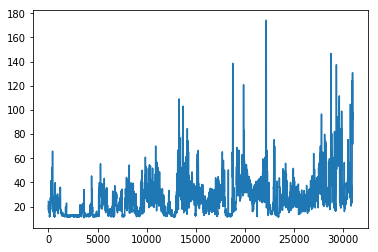

a grad norms [1199.0184, 1209.3823, 14.780716, 163.19295, 1315.3654, 3.0047644e-07, 2.9725017e-05, 3.4094786e-08]
aloss nan closs 6.323186 vloss 66.09541
v grad norms [0.70176023, 0.55711806, 4.595486e-08, 0.28941047]
c grad norms [0.22479105, 1.4298975, 1.862842e-07, 0.005624821, 0.95461154]
m grad norms [233836130000.0, 5.197329, 5.5796836e-08, 0.092024334, 233834990000.0]
 ep,  31010  avg frames 114.25
abs action (1,) 0.3839244483183093
max reward 2.0
a grad norms [2612.2378, 2455.2988, 17.197435, 2287.249, 1278.0979, 3.0117957e-07, 0.00044544588, 4.890964e-07]
aloss nan closs 7.375925 vloss 59.42338
v grad norms [396397.03, 18.591875, 4.522772e-08, 400059.16]
c grad norms [2.599257, 2.2536979, 1.8689822e-07, 0.010311746, 12.268445]
m grad norms [1485273500000000.0, 16.317556, 5.5734386e-08, 3.5916202, 1485273500000000.0]
 ep,  31020  avg frames 110.25
abs action (1,) 2.662452220916748
max reward 2.0
a grad norms [1151.1588, 1135.9049, 14.93777, 158.25104, 1313.1193, 3.0141453e-07, 

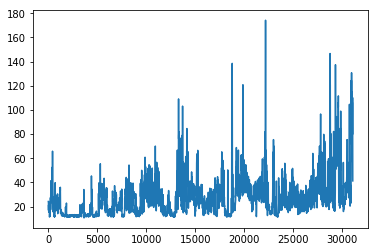

a grad norms [1120.1665, 1142.4875, 16.46498, 110.835724, 1273.4711, 2.9092266e-07, 0.00012756245, 1.6071711e-07]
aloss nan closs 5.6646366 vloss 55.343292
v grad norms [0.24224211, 0.5347636, 4.565983e-08, 0.24623841]
c grad norms [0.3606951, 1.2336082, 1.9409963e-07, 0.0056373593, 3.1950598]
m grad norms [81.26883, 27.422213, 5.6850734e-08, 2.3207433e-06, 45.032063]
 ep,  31110  avg frames 32.0
abs action (1,) 2.6640970706939697
max reward 2.0
a grad norms [1137.0612, 1153.1669, 16.96963, 120.23417, 1314.4141, 2.951973e-07, 0.0020034795, 3.572269e-06]
aloss nan closs 5.204014 vloss 53.518326
v grad norms [0.99227554, 1.4535836, 4.593392e-08, 0.23427056]
c grad norms [0.55353415, 1.1061215, 1.9507154e-07, 0.0025049145, 0.13590823]
m grad norms [130.97066, 48.84788, 5.6931437e-08, 6.068369e-06, 32.661873]
 ep,  31120  avg frames 21.15
abs action (1,) 2.6581742763519287
max reward 2.0
a grad norms [1208.202, 1201.0197, 17.069761, 167.05515, 1373.2905, 2.9646918e-07, 0.0017874636, 5.0449

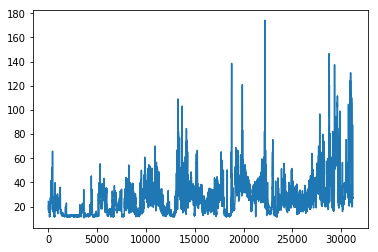

a grad norms [1341.4637, 1355.7493, 15.231763, 94.07204, 1600.7388, 3.0190273e-07, 0.0013084627, 0.00023904664]
aloss nan closs 4.527219 vloss 48.499077
v grad norms [0.38653174, 0.14916112, 4.8425694e-08, 0.1525171]
c grad norms [0.18489414, 0.6033286, 2.0368248e-07, 0.0020217723, 0.17587464]
m grad norms [1743516200000.0, 4.368236, 5.802163e-08, 0.09201759, 1743522200000.0]
 ep,  31210  avg frames 25.0
abs action (1,) 2.6546578407287598
max reward 2.0
a grad norms [1398.3247, 1427.4286, 16.359205, 110.23059, 1588.0078, 3.0061963e-07, 0.0021380421, 5.2428877e-06]
aloss nan closs 3.8018873 vloss 48.836525
v grad norms [88784110.0, 1.8774567, 4.8458663e-08, 88769800.0]
c grad norms [0.31452876, 0.66239995, 2.0525702e-07, 0.0014603348, 0.3772889]
m grad norms [1180650200000.0, 22.567587, 5.8096592e-08, 0.2870265, 1180640200000.0]
 ep,  31220  avg frames 20.2
abs action (1,) 2.6336405277252197
max reward 2.0
a grad norms [1434.8536, 1444.0726, 17.432158, 70.887665, 1687.5594, 3.015871e-07

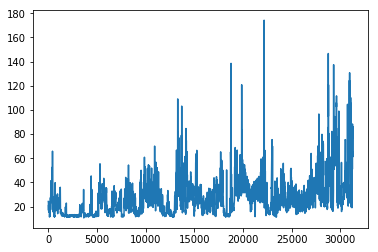

a grad norms [1312.0182, 1310.3153, 15.20916, 95.58053, 1596.3267, 3.0603806e-07, 0.00070976216, 5.7906635e-07]
aloss nan closs 5.2799077 vloss 50.117325
v grad norms [33272742.0, 1.6078291, 4.9669083e-08, 33274218.0]
c grad norms [0.3459321, 0.95643973, 2.0992961e-07, 0.0035327927, 0.23004091]
m grad norms [4166319900.0, 31.75303, 5.9312356e-08, 0.07599238, 4166606800.0]
 ep,  31310  avg frames 81.6
abs action (1,) 2.6045873165130615
max reward 2.0
a grad norms [1508.951, 1511.2812, 16.428862, 75.902695, 1793.1832, 3.0523407e-07, 0.00013641005, 6.1399226e-07]
aloss nan closs 4.5284686 vloss 54.14931
v grad norms [3.2289343, 4.6973414, 4.96383e-08, 0.24265026]
c grad norms [0.2602384, 0.7682351, 2.1125328e-07, 0.0046521425, 2.0020316]
m grad norms [4101606700.0, 21.62425, 5.936945e-08, 0.0016048942, 4101102600.0]
 ep,  31320  avg frames 65.65
abs action (1,) 2.576716423034668
max reward 2.0
a grad norms [1325.451, 1331.0112, 16.047815, 45.484585, 1581.7306, 3.0400335e-07, 1.777272e-05,

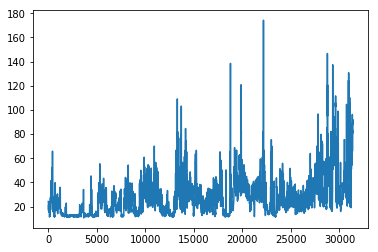

a grad norms [1252.2767, 1256.257, 16.00392, 73.52554, 1452.2698, 2.9466221e-07, 1.929489e-06, 9.687079e-07]
aloss nan closs 4.7059393 vloss 45.105305
v grad norms [9.217083, 12.591002, 4.7355684e-08, 0.33385572]
c grad norms [0.44370857, 0.9547965, 2.1914407e-07, 0.005780066, 3.4211762]
m grad norms [6468310400000.0, 7.1952243, 5.9742845e-08, 0.05019556, 6468307000000.0]
 ep,  31410  avg frames 101.55
abs action (1,) 2.5824134349823
max reward 2.0
a grad norms [1501.8242, 1472.8442, 15.745112, 647.5504, 1366.1138, 3.0071018e-07, 0.0004301481, 1.3801465e-06]
aloss nan closs 4.2664814 vloss 42.363968
v grad norms [844937.2, 0.2501242, 4.705618e-08, 845161.5]
c grad norms [0.10050767, 0.57098156, 2.196436e-07, 0.0019151435, 0.8702337]
m grad norms [4752370000.0, 15.36682, 5.9649814e-08, 0.010741084, 4752657000.0]
 ep,  31420  avg frames 113.9
abs action (1,) 2.5253078937530518
max reward 2.0
a grad norms [927.7993, 931.33844, 15.385058, 39.518517, 1084.7954, 2.9995013e-07, 1.5982841e-05,

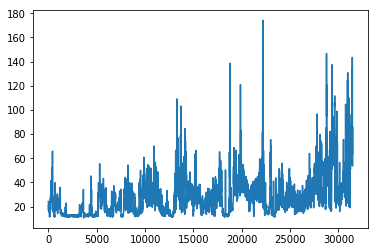

a grad norms [1224.3932, 1228.5052, 15.120261, 81.97599, 1407.9204, 2.8373998e-07, 0.0006897184, 4.546348e-07]
aloss nan closs 3.503882 vloss 40.360397
v grad norms [1.2643594, 0.622056, 4.763878e-08, 0.20431729]
c grad norms [0.043728914, 0.5465408, 2.3057397e-07, 0.0023756146, 0.47151756]
m grad norms [11137143000.0, 6.2656956, 6.147037e-08, 0.012586984, 11136802000.0]
 ep,  31510  avg frames 54.5
abs action (1,) 1.6815971360447077
max reward 2.0
a grad norms [976.80176, 983.0793, 13.849419, 136.38994, 1041.0056, 2.8404207e-07, 0.00022384636, 5.6870288e-08]
aloss nan closs 4.140487 vloss 31.75975
v grad norms [1.0265876, 1.7023467, 4.768165e-08, 0.38744447]
c grad norms [0.76941043, 0.87935174, 2.3184624e-07, 0.001197363, 0.0052713137]
m grad norms [32425597000.0, 7.6928787, 6.163568e-08, 0.014340072, 32425960000.0]
 ep,  31520  avg frames 47.0
abs action (1,) 0.9934392201207459
max reward 2.0
a grad norms [1151.2675, 1156.109, 14.612628, 84.83272, 1317.4695, 2.840153e-07, 0.00013990

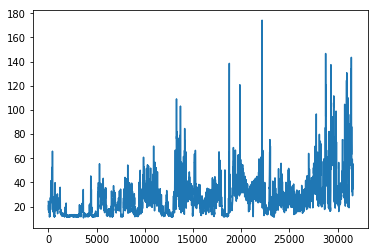

a grad norms [1025.7106, 1013.5052, 15.67215, 160.16238, 1122.8549, 2.6711325e-07, 0.0002995047, 3.3947536e-08]
aloss nan closs 3.466787 vloss 38.797012
v grad norms [0.74280095, 1.5884732, 4.7376407e-08, 0.26233336]
c grad norms [15898.002, 0.5602613, 2.3850743e-07, 0.008404867, 24059.266]
m grad norms [1832921600.0, 5.9843183, 6.2310804e-08, 0.0020805628, 1832878200.0]
 ep,  31610  avg frames 40.85
abs action (1,) 1.8632341623306274
max reward 2.0
a grad norms [932.7078, 933.76337, 14.961193, 95.01366, 1045.5233, 2.6736782e-07, 0.00043638315, 2.6851828e-07]
aloss nan closs 3.1825788 vloss 28.678978
v grad norms [2.309226, 1.3958937, 4.767851e-08, 0.22366989]
c grad norms [1.5573212, 0.62132996, 2.3987084e-07, 0.002441697, 5.7659335]
m grad norms [64383370000000.0, 3.73016, 6.24298e-08, 0.33236888, 64383305000000.0]
 ep,  31620  avg frames 39.4
abs action (1,) 2.0770156383514404
max reward 2.0
a grad norms [1052.3405, 1047.0167, 15.482727, 138.05278, 1157.9028, 2.720374e-07, 0.0003139

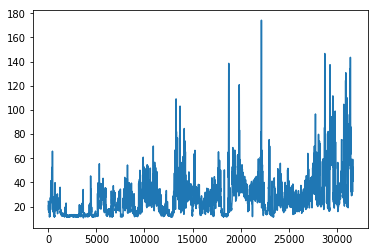

a grad norms [986.24567, 984.0135, 16.032633, 126.505585, 1083.5532, 2.7227006e-07, 8.7902394e-05, 7.2922596e-08]
aloss nan closs 3.8383284 vloss 33.72629
v grad norms [6501.6333, 6.0282655, 4.4955346e-08, 6689.381]
c grad norms [1.2493243, 0.5371192, 2.461841e-07, 0.0043142806, 3.9228923]
m grad norms [607121800000.0, 3.1946964, 6.284044e-08, 0.010806955, 607124500000.0]
 ep,  31710  avg frames 57.15
abs action (1,) 0.28456720631996196
max reward 2.0
a grad norms [1104.4669, 1099.9691, 15.587016, 202.14128, 1161.2739, 2.7249064e-07, 5.0690523e-05, 5.368261e-08]
aloss nan closs 3.4071836 vloss 28.683916
v grad norms [178901140.0, 5.6420016, 4.3721993e-08, 178888260.0]
c grad norms [1096.6306, 0.7567253, 2.487582e-07, 0.0098449085, 1700.5287]
m grad norms [1441726300000.0, 3.3317776, 6.284996e-08, 0.0023062245, 1441727400000.0]
 ep,  31720  avg frames 61.9
abs action (1,) 2.020941734313965
max reward 2.0
a grad norms [733.1404, 730.6885, 12.995323, 54.996597, 825.2589, 2.7027184e-07, 8.

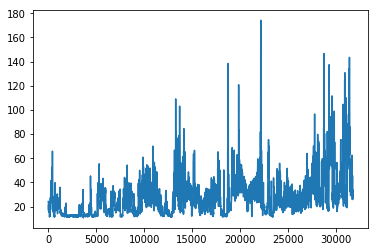

a grad norms [1197.9579, 1200.0746, 14.959377, 86.514755, 1359.73, 2.7331564e-07, 7.200796e-05, 7.496231e-08]
aloss nan closs 3.2194884 vloss 34.280384
v grad norms [0.5054941, 0.32560298, 4.32855e-08, 0.18485455]
c grad norms [2248.9011, 0.44838333, 2.6644088e-07, 0.0013638092, 3445.0955]
m grad norms [82313900000.0, 2.721748, 6.341139e-08, 0.024024671, 82313680000.0]
 ep,  31810  avg frames 34.3
abs action (1,) 1.7451164722442627
max reward 2.0
a grad norms [1240.5469, 1240.1223, 14.940089, 59.077236, 1451.8239, 2.7470062e-07, 4.338412e-05, 1.3634979e-09]
aloss nan closs 3.4654953 vloss 31.597454
v grad norms [0.15298732, 0.3557959, 4.3916277e-08, 0.18426053]
c grad norms [0.16609132, 0.45032337, 2.676392e-07, 0.0009228907, 0.09837078]
m grad norms [4617740500000.0, 2.905097, 6.34741e-08, 0.05482756, 4617740000000.0]
 ep,  31820  avg frames 28.7
abs action (1,) 2.1746487617492676
max reward 2.0
a grad norms [1653.0592, 1660.0978, 14.873948, 196.5294, 1829.1239, 2.7350032e-07, 0.00012

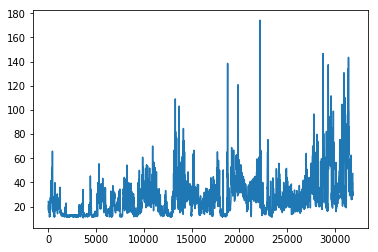

a grad norms [1971.5209, 1975.7897, 15.532239, 350.42743, 2319.068, 2.800797e-07, 1.7404729e-05, 2.1242688e-07]
aloss nan closs 3.019763 vloss 26.397646
v grad norms [25.3021, 1.9350911, 4.5752543e-08, 30.218473]
c grad norms [0.044253834, 0.17702481, 2.803212e-07, 0.00086252345, 0.07435571]
m grad norms [333887640000.0, 1.005629, 6.3472235e-08, 0.035935525, 333887730000.0]
 ep,  31910  avg frames 52.0
abs action (1,) 2.3417880535125732
max reward 2.0
a grad norms [1927.84, 1922.2191, 15.843174, 76.02391, 2259.081, 2.806678e-07, 0.00024495373, 3.1410468e-07]
aloss nan closs 1.9845849 vloss 15.126587
v grad norms [1.0500901, 0.9398834, 4.591038e-08, 0.049787972]
c grad norms [0.08220366, 0.17517887, 2.8068007e-07, 0.0005621731, 0.022495518]
m grad norms [329449300000.0, 0.79070455, 6.3548676e-08, 0.12778251, 329449180000.0]
 ep,  31920  avg frames 70.75
abs action (1,) 2.459559440612793
max reward 2.0
a grad norms [2615.738, 2611.5525, 16.254698, 42.072166, 3223.1963, 2.8137705e-07, 6.2

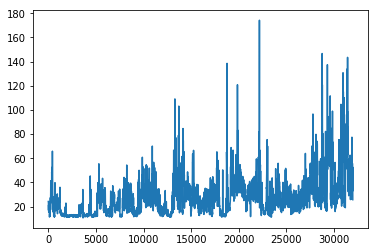

a grad norms [1510.7926, 1511.6276, 15.256995, 221.59814, 1650.1675, 2.810668e-07, 1.2822032e-05, 7.001304e-09]
aloss nan closs 2.5646129 vloss 21.571606
v grad norms [0.038958583, 0.09754121, 4.4350926e-08, 0.15544078]
c grad norms [0.06360029, 0.13484365, 2.9273963e-07, 0.0007261741, 0.4151007]
m grad norms [215859540000.0, 1.1781199, 6.428699e-08, 0.00085120276, 215859120000.0]
 ep,  32010  avg frames 42.2
abs action (1,) 2.2994751930236816
max reward 2.0
a grad norms [2082.8396, 2082.924, 15.064552, 68.43735, 2534.9692, 2.80262e-07, 2.3220591e-06, 2.135032e-07]
aloss nan closs 2.5699873 vloss 16.49329
v grad norms [0.050600022, 0.060581546, 4.518732e-08, 0.032096367]
c grad norms [2.115386, 0.11106212, 2.9392373e-07, 0.00081342383, 4.4406524]
m grad norms [4152632600.0, 1.0551546, 6.423584e-08, 0.001377276, 4152596700.0]
 ep,  32020  avg frames 49.3
abs action (1,) 2.058854818344116
max reward 2.0
a grad norms [2232.5955, 2231.9094, 14.651062, 122.91352, 2700.5117, 2.8471754e-07, 0

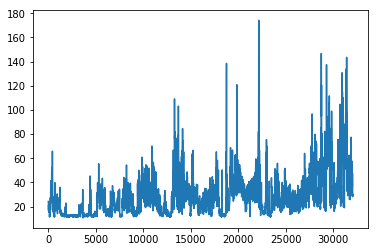

a grad norms [3937.74, 3933.2773, 15.245392, 50.114975, 4994.082, 2.7823754e-07, 0.00119428, 2.5045634e-07]
aloss nan closs 1.9736925 vloss 18.135643
v grad norms [1.6151053, 0.38669944, 4.649044e-08, 0.5396464]
c grad norms [0.045911193, 0.07593593, 3.067331e-07, 0.00016610646, 0.005081479]
m grad norms [453947460000.0, 0.36871088, 6.546225e-08, 0.0013498194, 453947130000.0]
 ep,  32110  avg frames 39.85
abs action (1,) 2.1046600341796875
max reward 2.0
a grad norms [2597.9822, 2602.8838, 14.055957, 479.72244, 3203.094, 2.764541e-07, 0.00013256462, 6.217012e-07]
aloss nan closs 1.8422917 vloss 23.484453
v grad norms [0.4483793, 0.29678813, 4.6064542e-08, 0.025534386]
c grad norms [0.0449755, 0.09827922, 3.0835e-07, 0.00022625842, 0.015559162]
m grad norms [6209562000000.0, 0.41690686, 6.5451765e-08, 0.050662804, 6209566000000.0]
 ep,  32120  avg frames 41.85
abs action (1,) 1.6707298755645752
max reward 2.0
a grad norms [4749.485, 4743.657, 15.502444, 38.513783, 6021.2446, 2.741337e-0

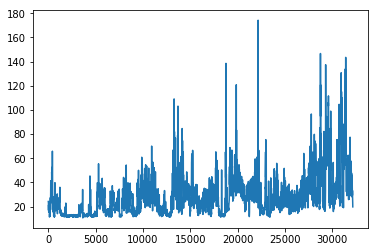

a grad norms [4425.3057, 4421.3735, 14.931015, 152.78766, 5459.666, 2.7877405e-07, 0.00029616026, 3.225582e-07]
aloss nan closs 1.4861253 vloss 24.697779
v grad norms [18839744.0, 2.8803384, 4.6141214e-08, 18847442.0]
c grad norms [2.4624815, 0.18953964, 3.264324e-07, 0.00058833335, 4.646881]
m grad norms [47919410000.0, 0.20261373, 6.662834e-08, 0.7365711, 47919055000.0]
 ep,  32210  avg frames 24.4
abs action (1,) 1.012697458267212
max reward 2.0
a grad norms [2224.9353, 2225.8738, 14.645669, 44.974716, 2735.15, 2.778195e-07, 3.757802e-05, 9.247895e-10]
aloss nan closs 2.0671518 vloss 24.319487
v grad norms [19814562000.0, 1.1911591, 4.564592e-08, 19814412000.0]
c grad norms [1.8789035, 1.0383544, 3.2759434e-07, 0.00094367034, 2.2506335]
m grad norms [14438842000.0, 0.5321507, 6.654495e-08, 0.0038550964, 14438755000.0]
 ep,  32220  avg frames 32.9
abs action (1,) 1.6571372747421265
max reward 2.0
a grad norms [2194.6746, 2193.3704, 14.771426, 33.75143, 2690.8604, 2.7681492e-07, 3.999

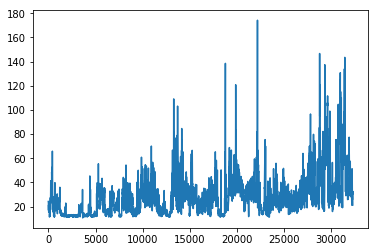

a grad norms [58553.33, 58700.59, 14.085476, 76111.35, 2398.6477, 2.7445688e-07, 0.00038253353, 2.3771906e-07]
aloss nan closs 1.7589296 vloss 23.200762
v grad norms [286443.4, 0.9558766, 4.416724e-08, 286183.47]
c grad norms [0.04122614, 0.105973214, 3.4393383e-07, 0.00032137948, 0.05567542]
m grad norms [166054350000.0, 0.87114143, 6.672451e-08, 0.0016391826, 166054870000.0]
 ep,  32310  avg frames 24.25
abs action (1,) 1.6695388555526733
max reward 2.0
a grad norms [2206.2903, 2199.7688, 14.262852, 195.30841, 2560.9026, 2.7565915e-07, 0.00047064162, 1.7088887e-07]
aloss nan closs 1.8821007 vloss 28.335531
v grad norms [23665.564, 0.10106657, 4.344771e-08, 23628.133]
c grad norms [0.08270802, 0.07630329, 3.4432364e-07, 0.0005804561, 0.36195478]
m grad norms [12476681000.0, 1.1045868, 6.6771e-08, 0.004168, 12476759000.0]
 ep,  32320  avg frames 23.95
abs action (1,) 0.8367549777030945
max reward 2.0
a grad norms [3038.0752, 3037.6594, 13.827775, 22.516518, 3842.8958, 2.7471003e-07, 0.

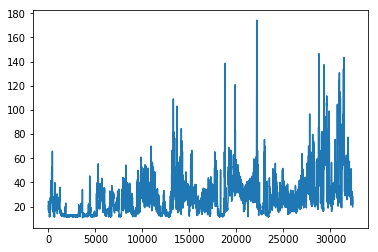

a grad norms [2950.3538, 2947.9202, 13.185249, 467.02582, 3316.6926, 2.7604213e-07, 0.00036298798, 6.7422924e-08]
aloss nan closs 1.421709 vloss 19.990446
v grad norms [8311.237, 0.19623955, 4.4606498e-08, 8311.282]
c grad norms [0.008194831, 0.06249306, 3.5483095e-07, 0.0003109495, 0.04284151]
m grad norms [1868208800.0, 0.30631134, 6.675444e-08, 0.0005311044, 1868192800.0]
 ep,  32410  avg frames 20.0
abs action (1,) 1.1425713430746167
max reward 2.0
a grad norms [1739.2139, 1739.9457, 14.057971, 131.14929, 2061.773, 2.720623e-07, 0.0007828123, 1.1745186e-06]
aloss nan closs 1.248218 vloss 25.367788
v grad norms [0.16558647, 0.17016585, 4.425236e-08, 0.012228881]
c grad norms [0.02863287, 0.04654675, 3.5631012e-07, 0.0001375714, 0.0030564943]
m grad norms [831465500.0, 0.7560448, 6.673395e-08, 0.005926706, 831489000.0]
 ep,  32420  avg frames 17.55
abs action (1,) 1.8565442562103271
max reward 2.0
a grad norms [2772.4182, 2774.3367, 13.608966, 440.0793, 3097.3389, 2.704189e-07, 0.000

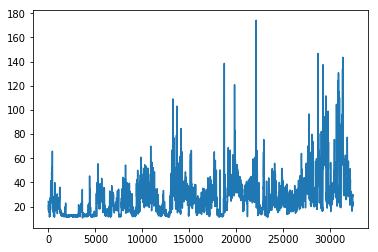

a grad norms [2369.1797, 2371.01, 15.570324, 92.35823, 2900.4941, 2.6842886e-07, 0.00044380734, 4.3741042e-07]
aloss nan closs 1.1779914 vloss 23.471638
v grad norms [1063724.8, 1.8002218, 4.3169155e-08, 1061363.1]
c grad norms [0.032426044, 0.07618609, 3.7198166e-07, 0.0002510286, 0.015345168]
m grad norms [39725100000.0, 0.93548006, 6.707248e-08, 0.0029170013, 39724890000.0]
 ep,  32510  avg frames 24.95
abs action (1,) 1.7203105688095093
max reward 2.0
a grad norms [1853.9232, 1857.2819, 15.054564, 96.09246, 2217.8286, 2.6772048e-07, 4.8967395e-06, 2.2098044e-08]
aloss nan closs 0.8258458 vloss 20.373253
v grad norms [0.1942815, 0.17117392, 4.256862e-08, 0.13536298]
c grad norms [0.010537495, 0.033401426, 3.7384964e-07, 0.00014012736, 0.008402367]
m grad norms [210178080000.0, 0.24762325, 6.704963e-08, 0.0064976253, 210178620000.0]
 ep,  32520  avg frames 18.35
abs action (1,) 1.0263442993164062
max reward 2.0
a grad norms [2302.405, 2300.7722, 14.522733, 35.22435, 2853.428, 2.66220

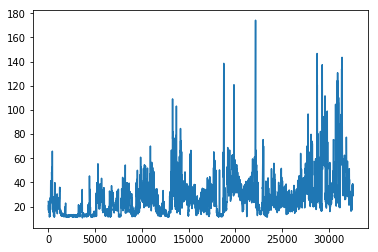

a grad norms [2014.1136, 2011.1821, 12.453467, 143.89944, 2405.7769, 2.7571494e-07, 7.3801007e-06, 6.640761e-09]
aloss nan closs 1.0434607 vloss 15.273098
v grad norms [0.117684625, 0.10165551, 4.230112e-08, 0.0066014887]
c grad norms [0.008567765, 0.036605418, 3.8579716e-07, 0.00013432426, 0.014279614]
m grad norms [330593760000.0, 0.2148658, 6.7660594e-08, 0.0010010329, 330593370000.0]
 ep,  32610  avg frames 24.75
abs action (1,) 2.625495195388794
max reward 2.0
a grad norms [2235.0305, 2236.1995, 12.588707, 46.9991, 2780.7158, 2.817125e-07, 1.5582859e-06, 2.9919052e-09]
aloss nan closs 1.0492282 vloss 18.904924
v grad norms [0.038420185, 0.03537292, 4.24231e-08, 0.003959055]
c grad norms [67.90972, 0.024122365, 3.85849e-07, 0.00010819185, 99.34428]
m grad norms [56023370000.0, 0.16311912, 6.7672055e-08, 0.0023764588, 56023250000.0]
 ep,  32620  avg frames 27.75
abs action (1,) 0.739085028077749
max reward 2.0
a grad norms [1770.9341, 1771.3297, 12.909873, 38.658684, 2185.2659, 2.81

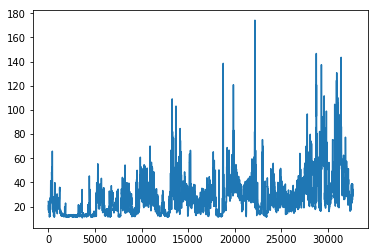

a grad norms [4299.8022, 4300.5522, 16.912561, 93.279106, 5364.334, 2.7243155e-07, 0.00012308967, 3.3091016e-08]
aloss nan closs 0.9265627 vloss 12.760564
v grad norms [0.3185084, 0.018594967, 3.9724437e-08, 0.2741908]
c grad norms [0.14710826, 0.030968454, 3.9383792e-07, 0.00022340764, 0.42328373]
m grad norms [2227902200.0, 0.16598642, 6.7845306e-08, 0.0012084177, 2227907300.0]
 ep,  32710  avg frames 27.95
abs action (1,) 1.2391456365585327
max reward 2.0
a grad norms [2659.847, 2660.1528, 16.083162, 44.415512, 3291.3804, 2.7478544e-07, 3.7460017e-05, 2.1568377e-08]
aloss nan closs 1.216006 vloss 11.898957
v grad norms [0.12024055, 0.09640694, 3.948036e-08, 0.0047656936]
c grad norms [0.13099283, 0.03998275, 3.9408258e-07, 8.457375e-05, 0.10128493]
m grad norms [2398942500.0, 0.15446168, 6.801138e-08, 0.0019408792, 2398938600.0]
 ep,  32720  avg frames 25.5
abs action (1,) 2.2816762924194336
max reward 2.0
a grad norms [2170.723, 2170.5735, 13.113912, 38.807575, 2677.7488, 2.7222538

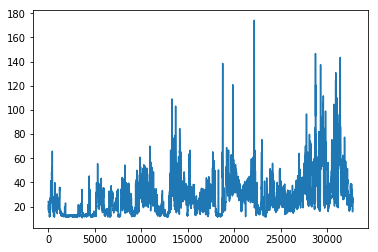

a grad norms [3853.7522, 3641.197, 14.825234, 72.636406, 4544.0293, 2.9264626e-07, 0.00014885064, 1.2991569e-07]
aloss nan closs 0.99416894 vloss 17.49665
v grad norms [0.13603075, 0.17361009, 4.16477e-08, 0.0041491743]
c grad norms [0.2351833, 0.028727671, 4.0566235e-07, 0.00029383894, 0.57243097]
m grad norms [8903226000.0, 0.27503675, 6.7855744e-08, 0.000580728, 8903178000.0]
 ep,  32810  avg frames 24.25
abs action (1,) 2.247101306915283
max reward 2.0
a grad norms [2402.2104, 2402.9695, 15.108464, 39.809414, 2960.8364, 2.8618294e-07, 0.00016682636, 3.5798372e-08]
aloss nan closs 1.1288254 vloss 11.119766
v grad norms [6731.513, 0.09230578, 4.136773e-08, 6733.893]
c grad norms [0.020416431, 0.0341537, 4.0661334e-07, 6.652665e-05, 0.0032544415]
m grad norms [10684516000.0, 0.23311578, 6.773265e-08, 0.0010327116, 10684530000.0]
 ep,  32820  avg frames 22.9
abs action (1,) 1.5657767057418823
max reward 2.0
a grad norms [3035.381, 3035.118, 13.28489, 109.53787, 3726.9072, 2.9157712e-07

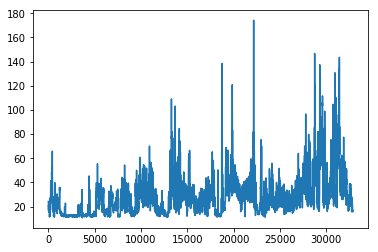

a grad norms [4298.3555, 4298.9194, 14.175174, 34.61223, 5418.137, 3.1343268e-07, 0.00015854424, 2.6719724e-07]
aloss nan closs 1.0143005 vloss 15.370808
v grad norms [2451611.8, 0.24756165, 3.903735e-08, 2452309.2]
c grad norms [720.86096, 0.06752094, 4.1747742e-07, 0.00040495527, 1092.0765]
m grad norms [2302705400.0, 0.16884862, 6.7304725e-08, 0.00052884006, 2302710500.0]
 ep,  32910  avg frames 16.85
abs action (1,) 0.26083777951844966
max reward 2.0
a grad norms [4908.3306, 4909.244, 13.211537, 56.895805, 6223.0903, 3.14632e-07, 9.1259055e-05, 1.0382748e-08]
aloss nan closs 1.1859924 vloss 11.694387
v grad norms [0.6895082, 0.034289334, 3.8644618e-08, 0.69249773]
c grad norms [38.62486, 0.025697215, 4.188885e-07, 0.000121917925, 60.06454]
m grad norms [425772900.0, 0.16741003, 6.7265226e-08, 0.00021649596, 425783400.0]
 ep,  32920  avg frames 21.75
abs action (1,) 1.6352209923746126
max reward 2.0
a grad norms [6816.5444, 6836.2017, 13.056465, 2481.349, 6394.8677, 3.185057e-07, 4.

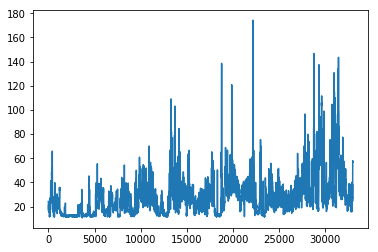

a grad norms [2036.0287, 2041.3656, 9.799523, 83.974594, 2492.985, 3.3181038e-07, 3.766299e-05, 1.7503407e-09]
aloss nan closs 1.7330902 vloss 23.851307
v grad norms [631616.25, 2.503331, 3.9860666e-08, 629294.94]
c grad norms [0.024834797, 0.05535062, 4.3018372e-07, 0.00011699763, 0.15912259]
m grad norms [156972430000.0, 0.3840392, 6.747303e-08, 0.09132219, 156972630000.0]
 ep,  33010  avg frames 57.55
abs action (1,) 1.8297955989837646
max reward 2.0
a grad norms [2352.405, 2341.7832, 10.4206915, 143.04053, 2862.8247, 3.336681e-07, 0.0004113582, 7.76025e-07]
aloss nan closs 1.8210679 vloss 21.448156
v grad norms [1.3093867, 0.54359454, 4.0303146e-08, 0.33093742]
c grad norms [0.010137783, 0.061536238, 4.3201786e-07, 0.00011985047, 0.07733097]
m grad norms [72836880000.0, 0.15381648, 6.748791e-08, 0.009045145, 72836870000.0]
 ep,  33020  avg frames 50.35
abs action (1,) 2.387930393218994
max reward 2.0
a grad norms [1992.2002, 1993.6392, 10.162557, 61.99461, 2465.5376, 3.348243e-07, 

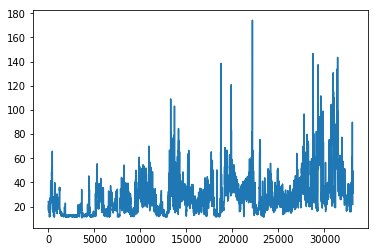

a grad norms [1271.2062, 1265.3341, 12.859721, 183.62875, 1371.0559, 3.378142e-07, 0.00016639176, 1.17453624e-07]
aloss nan closs 3.0896146 vloss 44.974407
v grad norms [4.0583215, 0.32710287, 4.201399e-08, 3.7722561]
c grad norms [0.07852426, 0.20100588, 4.4664253e-07, 0.00033972843, 0.54960054]
m grad norms [296996470000.0, 0.770484, 6.7995124e-08, 0.0018301985, 296996040000.0]
 ep,  33110  avg frames 23.9
abs action (1,) 1.8639121988269867
max reward 2.0
a grad norms [1467.9647, 1468.5948, 12.48968, 140.2747, 1693.4834, 3.3670202e-07, 1.5508148e-07, 3.0536565e-08]
aloss nan closs 3.4878182 vloss 42.83132
v grad norms [0.19013946, 0.28767613, 4.1846047e-08, 0.036801767]
c grad norms [0.039879095, 0.26247078, 4.4660183e-07, 0.00047117565, 0.23845674]
m grad norms [2641695000.0, 0.716613, 6.795385e-08, 0.00059546635, 2641651200.0]
 ep,  33120  avg frames 23.55
abs action (1,) 1.4093709611309615
max reward 2.0
a grad norms [1623.9933, 1619.7706, 12.801997, 130.54477, 1903.1063, 3.345011

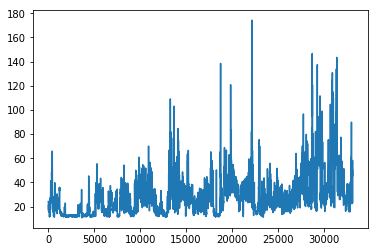

a grad norms [1338.6581, 1308.1332, 13.326787, 108.25674, 1520.1053, 3.1325456e-07, 3.911406e-06, 2.585568e-07]
aloss nan closs 3.8769221 vloss 53.839607
v grad norms [24786092000.0, 3.616082, 4.2379963e-08, 24786668000.0]
c grad norms [0.10299221, 0.38510957, 4.5735155e-07, 0.0006357497, 0.19626807]
m grad norms [416685500000.0, 1.3284483, 6.7641345e-08, 0.008207207, 416685460000.0]
 ep,  33210  avg frames 31.8
abs action (1,) 2.0591394901275635
max reward 2.0
a grad norms [1447.9977, 1450.6195, 14.188315, 129.90546, 1663.1354, 3.1184013e-07, 2.3718729e-05, 1.2298774e-08]
aloss nan closs 3.6996412 vloss 55.320946
v grad norms [0.27880546, 0.4250164, 4.2515907e-08, 0.060290445]
c grad norms [2.0738068, 0.40484205, 4.597542e-07, 0.0010968252, 5.593334]
m grad norms [18779443000000.0, 0.8730147, 6.768318e-08, 0.05220063, 18779445000000.0]
 ep,  33220  avg frames 26.65
abs action (1,) 0.45175987246180765
max reward 2.0
a grad norms [1319.0203, 1319.3977, 12.344639, 150.82306, 1488.9559, 3

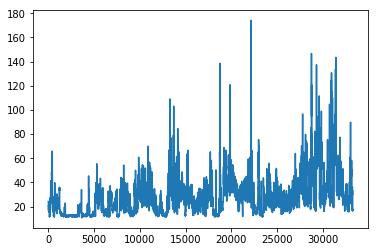

a grad norms [1388.3121, 1389.1102, 13.630764, 105.51669, 1608.5975, 2.9736492e-07, 8.6142485e-05, 2.1957526e-08]
aloss nan closs 3.106592 vloss 41.728134
v grad norms [101894.9, 0.20740362, 4.271591e-08, 101988.94]
c grad norms [0.056388244, 0.2534021, 4.6504078e-07, 0.0006020532, 0.1629443]
m grad norms [32138930000.0, 0.4785851, 6.769259e-08, 0.0013279488, 32138822000.0]
 ep,  33310  avg frames 19.85
abs action (1,) 1.5772624015808105
max reward 2.0
a grad norms [1390.106, 1391.504, 14.118263, 117.95288, 1599.5964, 2.9881724e-07, 0.00012843561, 6.685428e-08]
aloss nan closs 2.9090228 vloss 39.2995
v grad norms [195328.45, 1.5913817, 4.2718202e-08, 196238.83]
c grad norms [0.04561685, 0.23596907, 4.6414584e-07, 0.00059768726, 0.33654222]
m grad norms [2278793000000.0, 0.5859787, 6.758504e-08, 0.0033710636, 2278793700000.0]
 ep,  33320  avg frames 19.25
abs action (1,) 1.0449795722961426
max reward 2.0
a grad norms [1458.18, 1459.6313, 14.540836, 123.46582, 1682.9762, 2.933824e-07, 3.

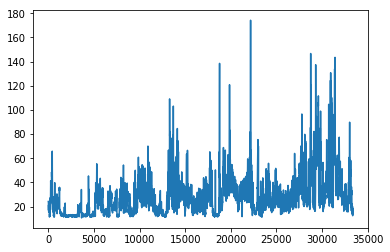

a grad norms [1215.3887, 1214.182, 13.81197, 149.11235, 1345.4691, 2.9378504e-07, 0.00030718025, 0.0016163592]
aloss nan closs 3.59918 vloss 51.0365
v grad norms [0.45942816, 0.80078554, 4.2882757e-08, 0.07973943]
c grad norms [0.05821763, 0.345034, 4.654614e-07, 0.0011382429, 0.2506456]
m grad norms [8248080400.0, 0.84098816, 6.741758e-08, 0.0024853994, 8248031700.0]
 ep,  33410  avg frames 16.1
abs action (1,) 1.9715380668640137
max reward 2.0
a grad norms [1370.6442, 1368.8344, 14.029712, 149.4047, 1543.0142, 2.910231e-07, 0.00020997268, 4.5142477e-07]
aloss nan closs 2.8021657 vloss 42.41777
v grad norms [61750.26, 0.16474916, 4.312912e-08, 61648.45]
c grad norms [0.48230684, 0.21003796, 4.6342885e-07, 0.0012265396, 1.7725258]
m grad norms [465683100000.0, 0.68870044, 6.719238e-08, 0.0018284541, 465682400000.0]
 ep,  33420  avg frames 15.6
abs action (1,) 0.9054855704307556
max reward 2.0
a grad norms [1288.6224, 1288.4886, 13.9239235, 172.66882, 1418.0425, 2.9154538e-07, 7.80798e-

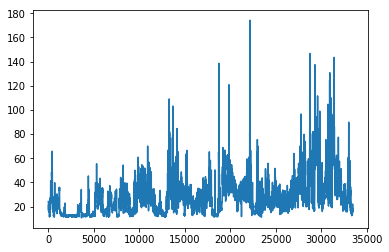

a grad norms [2282.116, 2277.3186, 11.724772, 91.06561, 2790.9043, 2.7750613e-07, 1.1851704e-06, 8.1621945e-09]
aloss nan closs 2.7624207 vloss 38.58173
v grad norms [0.21974011, 0.19992064, 4.1011905e-08, 0.032186765]
c grad norms [0.072552785, 0.15240547, 4.74696e-07, 0.00019635423, 0.023397425]
m grad norms [919820900000.0, 0.41614664, 6.718315e-08, 0.0033635944, 919820500000.0]
 ep,  33510  avg frames 19.0
abs action (1,) 2.0920655727386475
max reward 2.0
a grad norms [2184.1194, 2181.1218, 10.989886, 90.38232, 2670.8933, 2.6495607e-07, 2.5816635e-05, 8.321322e-09]
aloss nan closs 2.8339605 vloss 31.90226
v grad norms [259.9847, 0.07538632, 4.0146798e-08, 258.7244]
c grad norms [8057.2754, 0.113191724, 4.7533058e-07, 0.00011531694, 12027.546]
m grad norms [2690424200000.0, 0.28471422, 6.722386e-08, 0.0019024397, 2690423000000.0]
 ep,  33520  avg frames 22.7
abs action (1,) 2.0509607791900635
max reward 2.0
a grad norms [2096.7517, 2095.754, 12.370644, 163.2753, 2484.9363, 2.6646524

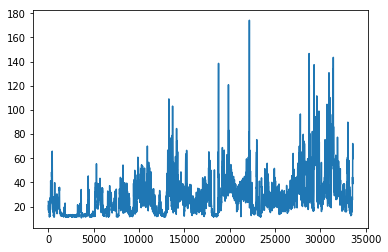

a grad norms [1938.8145, 1939.3833, 12.004083, 70.51839, 2378.6697, 2.5032827e-07, 0.00010967868, 1.1435938e-07]
aloss nan closs 2.8166637 vloss 18.303305
v grad norms [16.823366, 0.09590902, 3.809142e-08, 16.209402]
c grad norms [0.047826663, 0.21017216, 4.845206e-07, 0.00044017952, 0.1975389]
m grad norms [249664570000.0, 0.3080175, 6.6264256e-08, 0.0024163818, 249664700000.0]
 ep,  33610  avg frames 65.9
abs action (1,) 1.40183424949646
max reward 2.0
a grad norms [1514.7665, 1515.961, 11.95057, 220.58516, 1669.0648, 2.4822762e-07, 1.4757942e-05, 6.582321e-09]
aloss nan closs 2.6870453 vloss 20.212492
v grad norms [1449.8937, 0.076062985, 3.8359925e-08, 1434.0931]
c grad norms [0.022332149, 0.11577307, 4.8575276e-07, 0.000300765, 0.094121814]
m grad norms [19216605000.0, 0.31395796, 6.641745e-08, 0.001480077, 19216525000.0]
 ep,  33620  avg frames 66.95
abs action (1,) 1.620155930519104
max reward 2.0
a grad norms [1962.9596, 1962.2845, 13.491916, 65.29898, 2397.733, 2.514743e-07, 1

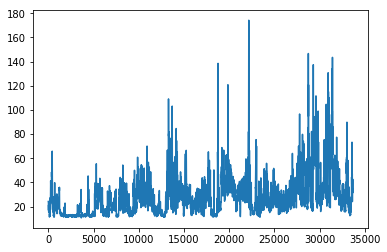

a grad norms [1981.5009, 1981.828, 13.096397, 47.36559, 2444.0732, 2.4974244e-07, 9.9421e-07, 1.4851184e-09]
aloss nan closs 3.61172 vloss 24.11314
v grad norms [341252.1, 0.18630797, 4.0648956e-08, 341311.78]
c grad norms [0.07327203, 0.19879645, 4.949918e-07, 0.00023199985, 0.10812964]
m grad norms [1240380000.0, 0.33636892, 6.629754e-08, 0.00087820063, 1240351500.0]
 ep,  33710  avg frames 35.5
abs action (1,) 2.4920201301574707
max reward 2.0
a grad norms [2292.683, 2293.6648, 13.758743, 60.35922, 2828.1277, 2.4853475e-07, 3.9932193e-06, 1.4924972e-09]
aloss nan closs 2.7487357 vloss 23.458677
v grad norms [1.7255949, 1.3107004, 4.1130857e-08, 0.3489506]
c grad norms [0.046622418, 0.13067447, 4.974761e-07, 0.00016889356, 0.17270823]
m grad norms [78701050.0, 0.261295, 6.643477e-08, 0.00022883814, 78699910.0]
 ep,  33720  avg frames 31.6
abs action (1,) 2.58533411345096
max reward 2.0
a grad norms [1811.3481, 1812.67, 13.59662, 99.38726, 2169.371, 2.4721325e-07, 1.3181012e-05, 1.134

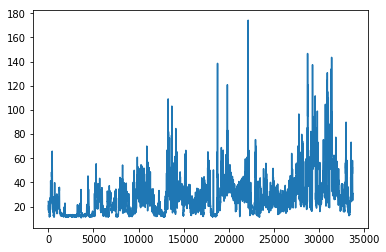

a grad norms [1977.458, 1978.59, 13.373746, 85.721054, 2401.3162, 2.4199008e-07, 1.011734e-05, 1.407887e-09]
aloss nan closs 3.6930573 vloss 35.142452
v grad norms [1.798997, 2.1698842, 4.0294726e-08, 0.028437609]
c grad norms [0.12419168, 0.24394414, 5.096291e-07, 0.00075335294, 0.77976555]
m grad norms [27964135000.0, 0.629973, 6.6482e-08, 0.0035714332, 27964156000.0]
 ep,  33810  avg frames 34.7
abs action (1,) 1.7994838953018188
max reward 2.0
a grad norms [2137.9746, 2146.9365, 14.647939, 141.06267, 2531.4512, 2.3307841e-07, 4.6696325e-05, 2.940532e-08]
aloss nan closs 3.6254237 vloss 28.309608
v grad norms [1003579.7, 0.47670433, 4.1311818e-08, 1003953.3]
c grad norms [0.08750994, 0.2326826, 5.1192393e-07, 0.000352061, 0.076284766]
m grad norms [228588400000.0, 0.8662293, 6.650745e-08, 0.0038503686, 228588470000.0]
 ep,  33820  avg frames 40.85
abs action (1,) 1.0594440698623657
max reward 2.0
a grad norms [2014.9911, 2027.5988, 12.200475, 135.48474, 2409.4097, 2.2701505e-07, 3.8

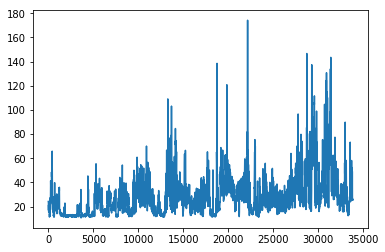

a grad norms [2774.7693, 2790.1042, 16.261831, 617.88007, 2883.439, 2.2556536e-07, 3.9303548e-05, 5.9447817e-08]
aloss nan closs 3.0406513 vloss 22.619825
v grad norms [0.07027419, 0.14446767, 4.0559588e-08, 0.05517043]
c grad norms [45547.047, 0.21049163, 5.2041827e-07, 0.0042179017, 68536.04]
m grad norms [9907050000.0, 0.39485836, 6.681361e-08, 0.001022427, 9907003000.0]
 ep,  33910  avg frames 29.15
abs action (1,) 0.8507897257804871
max reward 2.0
a grad norms [2077.3784, 2081.257, 14.110847, 160.23067, 2456.397, 2.2859048e-07, 4.8767556e-06, 6.042537e-09]
aloss nan closs 3.4395106 vloss 37.75461
v grad norms [999789.44, 0.38998118, 4.126503e-08, 1000877.3]
c grad norms [186.63002, 0.2655739, 5.222268e-07, 0.0013451553, 296.3361]
m grad norms [80951420000.0, 0.4853203, 6.684569e-08, 0.007699242, 80951510000.0]
 ep,  33920  avg frames 39.35
abs action (1,) 2.2470438480377197
max reward 2.0
a grad norms [2065.7612, 2071.819, 13.790339, 106.78146, 2485.3364, 2.2324248e-07, 6.361693e-

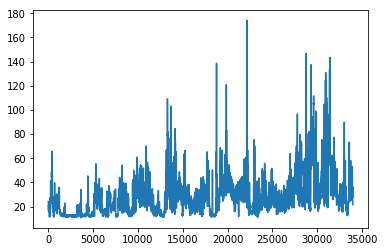

a grad norms [1925.2396, 1936.563, 11.760159, 219.54291, 2205.028, 2.3586155e-07, 7.754211e-06, 5.619621e-08]
aloss nan closs 3.457821 vloss 35.473484
v grad norms [87911.02, 0.16447754, 4.094353e-08, 87844.52]
c grad norms [0.04440137, 0.24290885, 5.370345e-07, 0.00030731098, 0.16691016]
m grad norms [3401644800000.0, 0.40240976, 6.7253445e-08, 0.2043084, 3401641600000.0]
 ep,  34010  avg frames 27.45
abs action (1,) 2.2574965953826904
max reward 2.0
a grad norms [1874.5864, 1880.9896, 13.0387335, 60.42612, 2290.3096, 2.2780178e-07, 2.5343916e-06, 1.8997964e-08]
aloss nan closs 2.729761 vloss 31.990454
v grad norms [3.439682, 0.8243267, 4.1087574e-08, 1.1429518]
c grad norms [0.18027428, 0.17937356, 5.377712e-07, 0.00036798266, 0.90106624]
m grad norms [548401480000.0, 0.29425576, 6.7214025e-08, 0.005889209, 548401550000.0]
 ep,  34020  avg frames 41.15
abs action (1,) 1.3974554538726807
max reward 2.0
a grad norms [1803.248, 1808.6313, 11.448616, 86.972824, 2190.4756, 2.301566e-07, 1

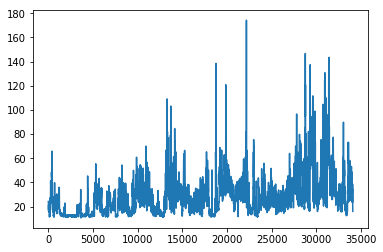

a grad norms [1802.3287, 1802.4935, 10.978652, 76.20089, 2205.3452, 2.290501e-07, 6.5782365e-06, 2.4758724e-09]
aloss nan closs 2.5132263 vloss 31.468794
v grad norms [2.1957948, 1.911112, 3.7820268e-08, 0.015448477]
c grad norms [0.954633, 0.14657821, 5.577803e-07, 0.00026784878, 2.5942695]
m grad norms [877102300.0, 0.25900412, 6.6915206e-08, 0.0006485218, 877097300.0]
 ep,  34110  avg frames 18.2
abs action (1,) 1.5476702451705933
max reward 2.0
a grad norms [1899.3754, 1901.9332, 10.361711, 52.85997, 2355.0295, 2.3229852e-07, 2.0723935e-05, 2.6089454e-08]
aloss nan closs 2.9740014 vloss 36.527676
v grad norms [0.4212427, 0.47353575, 3.6871104e-08, 0.021505201]
c grad norms [0.87497306, 0.19523443, 5.581238e-07, 0.00048495052, 2.5468342]
m grad norms [331666000000.0, 0.37190402, 6.698871e-08, 0.004331055, 331665470000.0]
 ep,  34120  avg frames 19.5
abs action (1,) 2.2715585231781006
max reward 2.0
a grad norms [1956.6475, 1959.5731, 10.41663, 188.74544, 2299.8438, 2.2934042e-07, 2.

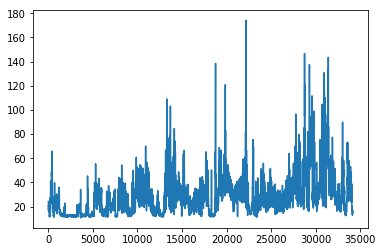

a grad norms [2495.0852, 2495.6316, 8.619123, 88.607025, 3128.5852, 2.3619202e-07, 0.00020362652, 5.7562164e-07]
aloss nan closs 2.259457 vloss 29.347795
v grad norms [0.53740764, 0.4264814, 3.8520167e-08, 0.013388835]
c grad norms [0.039589413, 0.14265135, 5.6716436e-07, 0.0002147173, 0.33254763]
m grad norms [29220856000.0, 0.45078802, 6.7643334e-08, 0.0075134845, 29220817000.0]
 ep,  34210  avg frames 16.0
abs action (1,) 2.5669453144073486
max reward 2.0
a grad norms [3493.6394, 3520.3933, 10.206346, 1070.2054, 3438.866, 2.3284804e-07, 0.0001218265, 1.0500214e-07]
aloss nan closs 2.944633 vloss 43.480194
v grad norms [508118.78, 1.4823476, 3.7358255e-08, 507291.25]
c grad norms [3549.4036, 0.23075607, 5.672022e-07, 0.00027311416, 5264.9575]
m grad norms [57085833000.0, 0.6722555, 6.759689e-08, 0.020891497, 57085820000.0]
 ep,  34220  avg frames 25.4
abs action (1,) 0.8399861501036632
max reward 2.0
a grad norms [2401.9407, 2402.1597, 10.393615, 43.09091, 3040.6194, 2.3592627e-07, 3

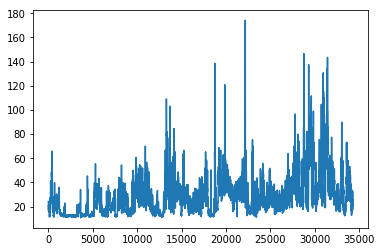

a grad norms [3317.3152, 3320.175, 11.658151, 238.70013, 4038.1785, 2.438105e-07, 9.719426e-05, 1.2034874e-07]
aloss nan closs 1.9693171 vloss 34.027393
v grad norms [151260.8, 0.035109133, 3.7028926e-08, 151335.5]
c grad norms [12328.883, 0.1215916, 5.7966366e-07, 0.0020610413, 18580.146]
m grad norms [974948600000.0, 0.39030313, 6.758594e-08, 0.0034618527, 974947300000.0]
 ep,  34310  avg frames 24.15
abs action (1,) 2.637036085128784
max reward 2.0
a grad norms [2659.3733, 2661.8113, 11.707547, 115.22775, 3291.4753, 2.3175448e-07, 3.0622217e-05, 2.2567578e-07]
aloss nan closs 1.7481289 vloss 29.343311
v grad norms [0.3618975, 0.48266065, 3.7374996e-08, 0.011703334]
c grad norms [13.794362, 0.085193135, 5.8096737e-07, 0.0002205128, 18.159252]
m grad norms [1983297400.0, 0.2904175, 6.7546466e-08, 0.00143283, 1983308800.0]
 ep,  34320  avg frames 25.35
abs action (1,) 0.864263484388632
max reward 2.0
a grad norms [2682.387, 2680.5593, 11.836154, 84.92624, 3375.4172, 2.281758e-07, 6.049

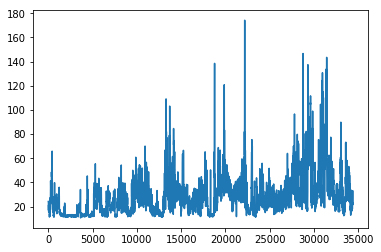

a grad norms [2026.6063, 2026.3184, 12.600253, 43.66447, 2533.9207, 1.9501677e-07, 2.3276523e-05, 3.7838294e-08]
aloss nan closs 1.0936676 vloss 19.880678
v grad norms [0.26105896, 0.33740723, 3.6857053e-08, 0.0073757856]
c grad norms [0.64912933, 0.04309286, 5.8667024e-07, 0.00010538951, 0.6144348]
m grad norms [928426240.0, 0.36744633, 6.671462e-08, 0.0010772184, 928403000.0]
 ep,  34410  avg frames 21.55
abs action (1,) 2.247830867767334
max reward 2.0
a grad norms [2127.3245, 2120.8667, 13.146365, 59.03641, 2640.7502, 1.9484223e-07, 9.137375e-07, 3.992658e-09]
aloss nan closs 0.84573704 vloss 15.62012
v grad norms [0.24782522, 0.20345299, 3.7048533e-08, 0.0044659306]
c grad norms [0.013173757, 0.034018748, 5.8769893e-07, 0.0001109284, 0.07626833]
m grad norms [602966340.0, 0.23097433, 6.6693325e-08, 0.0022463605, 602962100.0]
 ep,  34420  avg frames 25.6
abs action (1,) 2.4148685932159424
max reward 2.0
a grad norms [2157.0427, 2154.9177, 12.516198, 69.60893, 2673.0774, 1.9519784e-

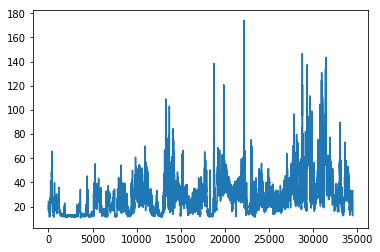

a grad norms [2200.19, 2207.1064, 12.182155, 221.49232, 2597.395, 2.1011522e-07, 5.064026e-06, 7.240588e-07]
aloss nan closs 0.6574488 vloss 13.896113
v grad norms [0.15721957, 0.08187584, 3.6381003e-08, 0.2020344]
c grad norms [0.011629397, 0.0218659, 6.0314784e-07, 5.0066563e-05, 0.0025535803]
m grad norms [14776856.0, 0.21699958, 6.6434986e-08, 0.0003713977, 14777080.0]
 ep,  34510  avg frames 22.3
abs action (1,) 2.271268367767334
max reward 2.0
a grad norms [1839.1582, 1839.7462, 12.272496, 16.794765, 2327.2273, 2.070011e-07, 6.2206386e-06, 1.0873041e-07]
aloss nan closs 0.7017592 vloss 12.008984
v grad norms [1.3391079, 0.10448155, 3.6669253e-08, 1.7301184]
c grad norms [830.77246, 0.019016415, 6.0293524e-07, 0.00018487072, 1255.626]
m grad norms [13740991000.0, 0.15146266, 6.65436e-08, 0.00039770792, 13741024000.0]
 ep,  34520  avg frames 19.55
abs action (1,) 2.041984796524048
max reward 2.0
a grad norms [2151.5989, 2160.2415, 11.618417, 279.55286, 2467.922, 2.067831e-07, 0.000

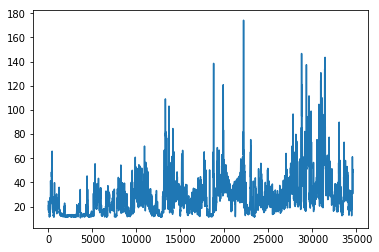

a grad norms [3994.2708, 4052.8708, 13.631824, 3270.9849, 1901.7081, 1.7241497e-07, 0.00020658503, 6.016898e-07]
aloss nan closs 1.0564684 vloss 28.241636
v grad norms [1.8483973, 2.1721475, 3.7358806e-08, 0.014162867]
c grad norms [1.0967674, 0.052395266, 6.1285726e-07, 0.00040047674, 2.2809165]
m grad norms [4309812000.0, 0.60169894, 6.661447e-08, 0.0007086207, 4309802500.0]
 ep,  34610  avg frames 54.15
abs action (1,) 0.7025410532951355
max reward 2.0
a grad norms [1484.7783, 1483.5253, 13.329869, 51.15514, 1813.6863, 1.6813259e-07, 2.721359e-05, 1.2564204e-08]
aloss nan closs 1.0733424 vloss 29.640577
v grad norms [1.5927776, 1.8825487, 3.788539e-08, 0.014016524]
c grad norms [0.012818281, 0.047237795, 6.162298e-07, 0.0003914196, 0.12099775]
m grad norms [7513885000.0, 0.4539852, 6.648647e-08, 0.002983133, 7513870000.0]
 ep,  34620  avg frames 57.05
abs action (1,) 1.3801347017288208
max reward 2.0
a grad norms [1615.6241, 1612.912, 13.165257, 112.02078, 1921.6189, 1.6710977e-07, 

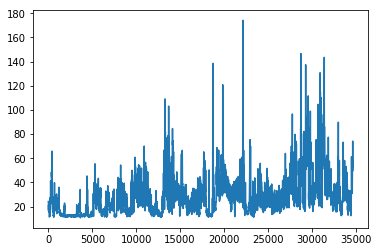

a grad norms [1781.8683, 1778.684, 13.409579, 115.069664, 2141.8162, 1.4067395e-07, 3.1341342e-06, 8.008167e-09]
aloss nan closs 1.7760375 vloss 22.634007
v grad norms [0.33853185, 0.4076519, 3.8789334e-08, 0.04281785]
c grad norms [0.020953408, 0.10332545, 6.3444605e-07, 0.00086466846, 0.23670822]
m grad norms [39949250000.0, 0.84136194, 6.601e-08, 0.0029048948, 39949353000.0]
 ep,  34710  avg frames 65.3
abs action (1,) 0.0069319600036702525
max reward 2.0
a grad norms [1526.0703, 1519.0629, 13.888435, 86.32073, 1828.034, 1.400048e-07, 0.00012566436, 2.3061308e-07]
aloss nan closs 1.9492705 vloss 26.969875
v grad norms [3.6419811, 4.673166, 3.863802e-08, 0.07342628]
c grad norms [0.037532616, 0.16209522, 6.383048e-07, 0.0009182263, 0.06342911]
m grad norms [7526363000.0, 1.718841, 6.590993e-08, 0.006888769, 7526422000.0]
 ep,  34720  avg frames 60.4
abs action (1,) 1.466077208518982
max reward 2.0
a grad norms [1726.8652, 1721.7257, 14.209926, 161.21646, 2020.4601, 1.4262599e-07, 1.4

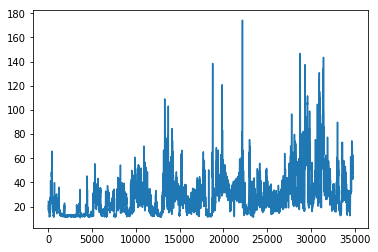

a grad norms [1574.2281, 1561.5186, 14.23602, 84.62029, 1904.743, 1.5085429e-07, 1.8291938e-05, 1.8043068e-09]
aloss nan closs 1.8766624 vloss 23.613173
v grad norms [0.69683665, 0.50227267, 3.751789e-08, 0.054270778]
c grad norms [0.09373263, 0.12761407, 6.511152e-07, 0.0011156244, 0.53013295]
m grad norms [631222960000.0, 0.7753461, 6.639119e-08, 0.06312014, 631222500000.0]
 ep,  34810  avg frames 31.4
abs action (1,) 0.09488767590987837
max reward 2.0
a grad norms [1703.8916, 1693.2181, 14.342044, 71.94632, 2071.4863, 1.5069033e-07, 0.00016449713, 1.7759709e-07]
aloss nan closs 2.2937198 vloss 21.479155
v grad norms [0.46303463, 0.7407276, 3.7310787e-08, 0.07440124]
c grad norms [0.017425224, 0.12844953, 6.524652e-07, 0.00075398874, 0.15193383]
m grad norms [62386930000.0, 0.95768994, 6.639285e-08, 0.00764871, 62386600000.0]
 ep,  34820  avg frames 22.45
abs action (1,) 1.8806824684143066
max reward 2.0
a grad norms [1763.5223, 1741.0231, 14.875053, 142.14462, 2078.4502, 1.5455417e-

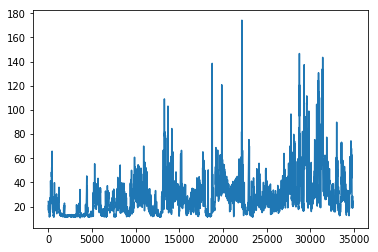

a grad norms [1860.8934, 1852.0757, 15.534207, 92.267944, 2250.15, 1.4304136e-07, 0.00022058959, 5.404066e-07]
aloss nan closs 2.0712461 vloss 18.355597
v grad norms [0.05481441, 0.06697746, 3.8198433e-08, 0.051735144]
c grad norms [0.039647877, 0.095652856, 6.71605e-07, 0.0002821701, 0.02111917]
m grad norms [29645445000.0, 0.6459775, 6.581079e-08, 0.00447009, 29645308000.0]
 ep,  34910  avg frames 23.65
abs action (1,) 1.416797161102295
max reward 2.0
a grad norms [1773.1266, 1767.3217, 14.23442, 90.21674, 2132.3247, 1.4019595e-07, 0.0002603235, 3.6488655e-07]
aloss nan closs 2.1495612 vloss 20.439655
v grad norms [196225540.0, 0.9732432, 3.785953e-08, 196228180.0]
c grad norms [0.16081494, 0.18249206, 6.718803e-07, 0.0013967276, 0.5962253]
m grad norms [304129500000.0, 1.11182, 6.57702e-08, 0.025954485, 304129670000.0]
 ep,  34920  avg frames 23.7
abs action (1,) 2.4083900451660156
max reward 2.0
a grad norms [1873.7001, 1867.3041, 13.539181, 97.93973, 2255.1077, 1.361088e-07, 0.000

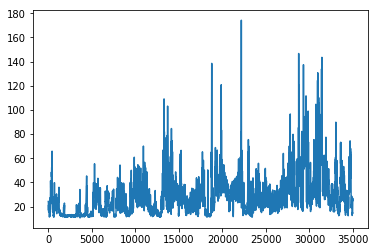

a grad norms [2365.3438, 2355.385, 15.029255, 122.01507, 2876.1082, 1.2818198e-07, 2.0762394e-07, 7.743999e-09]
aloss nan closs 1.7365397 vloss 16.88986
v grad norms [0.89883447, 0.68198794, 3.5800934e-08, 0.045559987]
c grad norms [1735.4564, 0.084676355, 6.8487924e-07, 0.00078151474, 2630.3977]
m grad norms [27975911000.0, 0.57128626, 6.53634e-08, 0.0014031919, 27975795000.0]
 ep,  35010  avg frames 24.65
abs action (1,) 1.0842642784118652
max reward 2.0
a grad norms [2171.4543, 2157.9326, 14.034135, 226.1565, 2523.9075, 1.2445868e-07, 3.8161647e-06, 7.189956e-10]
aloss nan closs 1.9096185 vloss 18.711452
v grad norms [0.4429092, 0.6909981, 3.5201197e-08, 0.05453511]
c grad norms [0.030528357, 0.10297939, 6.865511e-07, 0.00049788575, 0.029317787]
m grad norms [66486910000.0, 0.8936822, 6.534654e-08, 0.0013782531, 66487170000.0]
 ep,  35020  avg frames 24.45
abs action (1,) 2.4760022163391113
max reward 2.0
a grad norms [2058.5847, 2052.2986, 14.639668, 148.00803, 2449.4683, 1.2126189

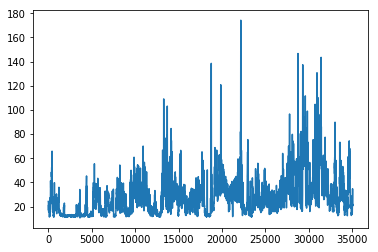

a grad norms [2456.1829, 2444.0378, 15.372159, 102.386375, 2998.593, 1.1761111e-07, 7.885152e-05, 6.2683704e-08]
aloss nan closs 2.3997276 vloss 12.030674
v grad norms [0.3656391, 0.58393675, 3.6004376e-08, 0.03887554]
c grad norms [0.042683613, 0.09810238, 6.953059e-07, 0.00030130407, 0.02239543]
m grad norms [5310806000.0, 0.42402408, 6.49608e-08, 0.0015388426, 5310830000.0]
 ep,  35110  avg frames 20.9
abs action (1,) 2.578706979751587
max reward 2.0
a grad norms [2589.5547, 2587.4248, 13.874883, 55.844364, 3228.069, 1.15132906e-07, 2.135899e-05, 4.572246e-07]
aloss nan closs 1.8848522 vloss 10.318126
v grad norms [9138.633, 0.26285407, 3.6461614e-08, 9071.934]
c grad norms [0.013862902, 0.054757398, 6.972732e-07, 0.00017326426, 0.031019023]
m grad norms [63345330000000.0, 0.2790633, 6.4929466e-08, 0.3770567, 63345302000000.0]
 ep,  35120  avg frames 19.35
abs action (1,) 2.4140126705169678
max reward 2.0
a grad norms [2662.844, 2662.2097, 16.17901, 75.40636, 3298.6697, 1.15102644e-

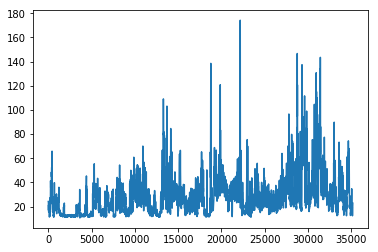

a grad norms [4485.0693, 4469.693, 9.670756, 85.99352, 5765.149, 1.09071486e-07, 0.0003606826, 5.281277e-07]
aloss nan closs 1.4605914 vloss 5.7723536
v grad norms [0.10054963, 0.0706811, 3.4812683e-08, 0.003357832]
c grad norms [0.025493883, 0.022522412, 7.0262877e-07, 2.5788235e-05, 0.09409696]
m grad norms [966653500.0, 0.094798915, 6.459922e-08, 0.0014099651, 966656700.0]
 ep,  35210  avg frames 22.25
abs action (1,) 2.514101266860962
max reward 2.0
a grad norms [4071.079, 4083.9534, 8.419718, 47.421597, 5229.9185, 1.09351e-07, 1.4509042e-05, 1.6088327e-08]
aloss nan closs 1.3211366 vloss 6.1000247
v grad norms [79.160774, 0.016352793, 3.458384e-08, 78.83843]
c grad norms [0.007098131, 0.017889934, 7.052824e-07, 1.8011679e-05, 0.018172158]
m grad norms [32651647000.0, 0.07710444, 6.4563785e-08, 0.0012365544, 32651643000.0]
 ep,  35220  avg frames 22.0
abs action (1,) 2.2869529724121094
max reward 2.0
a grad norms [4575.943, 4575.8804, 9.286422, 18.694971, 5933.884, 1.10441675e-07, 

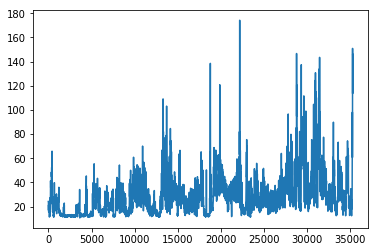

a grad norms [1021.3593, 1020.51685, 9.5609255, 26.273651, 1250.1782, 1.11421684e-07, 5.142105e-06, 8.429009e-09]
aloss nan closs 8.896562 vloss 213.3389
v grad norms [19085.055, 258.69022, 3.380796e-08, 16013.948]
c grad norms [0.5338225, 1.0356581, 7.027309e-07, 0.0014224082, 0.25177553]
m grad norms [290252100000.0, 3.2921762, 6.442338e-08, 0.0073071215, 290252000000.0]
 ep,  35310  avg frames 126.9
abs action (1,) 2.5010769367218018
max reward 2.0
a grad norms [674.8662, 677.7321, 9.92839, 27.417858, 800.7907, 1.1090876e-07, 6.3034764e-07, 1.1400132e-09]
aloss nan closs 11.1942215 vloss 259.23056
v grad norms [740643240000.0, 635.7587, 3.384065e-08, 740619200000.0]
c grad norms [2.8379543, 2.7548883, 7.053252e-07, 0.0034203462, 6.541682]
m grad norms [278179770000.0, 4.1776967, 6.4468225e-08, 0.022609524, 278179050000.0]
 ep,  35320  avg frames 120.35
abs action (1,) 2.577935218811035
max reward 2.0
a grad norms [1235.1458, 1190.2438, 9.871964, 548.87415, 1064.4954, 1.11793724e-07,

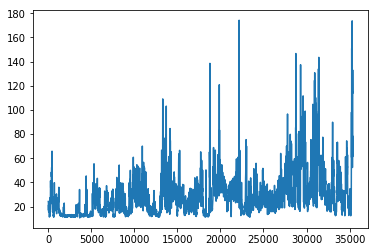

a grad norms [1049.8773, 1071.2206, 11.60498, 168.8209, 1130.9111, 1.1184202e-07, 1.5484883e-06, 2.8653398e-07]
aloss nan closs 9.211056 vloss 140.1219
v grad norms [128.64223, 175.57251, 3.527931e-08, 7.51556]
c grad norms [8.895059, 1.5866456, 7.1149566e-07, 0.0040853, 21.520056]
m grad norms [27266230000.0, 3.4395773, 6.505317e-08, 0.0064564976, 27266280000.0]
 ep,  35410  avg frames 121.7
abs action (1,) 1.7262359857559204
max reward 2.0
a grad norms [934.40643, 931.0283, 10.16896, 38.023228, 1141.8109, 1.10676545e-07, 1.4663473e-05, 2.8346067e-08]
aloss nan closs 11.721126 vloss 239.50487
v grad norms [15831115.0, 422.4039, 3.5213784e-08, 15968947.0]
c grad norms [0.84000003, 2.0177648, 7.128655e-07, 0.0027274808, 0.97631806]
m grad norms [26443448000.0, 8.11736, 6.510543e-08, 0.02323947, 26443252000.0]
 ep,  35420  avg frames 123.7
abs action (1,) 0.23907635006253194
max reward 2.0
a grad norms [910.04425, 910.78876, 11.986359, 24.544504, 1103.5449, 1.087592e-07, 9.2441536e-05, 6

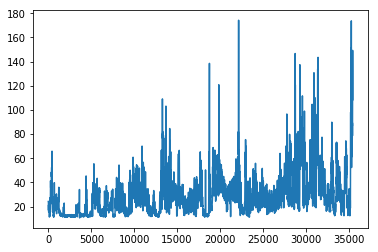

a grad norms [964.1364, 976.6276, 10.507447, 150.35242, 1045.8379, 1.0815413e-07, 5.4283864e-06, 5.0928584e-10]
aloss nan closs 12.508211 vloss 95.46978
v grad norms [24.757193, 27.991419, 3.510773e-08, 1.119274]
c grad norms [1.2424924, 2.2606778, 7.261505e-07, 0.002027989, 0.39206317]
m grad norms [19061910000000.0, 7.343724, 6.537048e-08, 0.006698523, 19061935000000.0]
 ep,  35510  avg frames 122.55
abs action (1,) 0.8347812294960022
max reward 2.0
a grad norms [1006.62164, 1000.0367, 11.962327, 85.129, 1171.924, 1.0896965e-07, 3.3869594e-07, 2.3712072e-09]
aloss nan closs 9.094753 vloss 56.238873
v grad norms [4.6900034, 1.1875459, 3.5115296e-08, 3.4410546]
c grad norms [3.7734761, 1.3195488, 7.260398e-07, 0.005009538, 12.068848]
m grad norms [186718960000.0, 4.4885545, 6.542279e-08, 0.005047034, 186718360000.0]
 ep,  35520  avg frames 133.45
abs action (1,) 1.1379812955856323
max reward 2.0
a grad norms [905.64105, 901.06323, 12.889416, 76.83185, 1032.1442, 1.09383336e-07, 1.24229

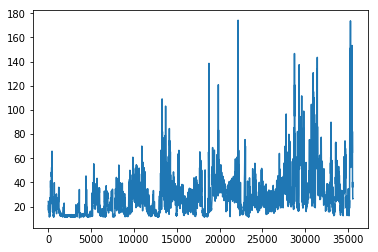

a grad norms [776.2072, 769.1301, 12.620467, 106.64316, 846.7341, 9.852274e-08, 9.021411e-05, 6.617492e-08]
aloss nan closs 6.200079 vloss 65.95235
v grad norms [4.956873, 0.37549973, 3.4114603e-08, 5.04192]
c grad norms [0.13980825, 0.7576034, 7.4287385e-07, 0.0025439623, 1.5821174]
m grad norms [117802930000.0, 2.809981, 6.5147866e-08, 0.032050774, 117802170000.0]
 ep,  35610  avg frames 26.75
abs action (1,) 0.7911079525947571
max reward 2.0
a grad norms [753.22925, 740.5091, 12.524915, 129.44096, 801.10114, 9.80057e-08, 0.00011415844, 1.221461e-07]
aloss nan closs 7.8937163 vloss 72.323425
v grad norms [6886529500.0, 1.2466918, 3.429295e-08, 6886426000.0]
c grad norms [0.3271279, 1.2429289, 7.4543e-07, 0.0040821037, 3.1708672]
m grad norms [80615740000.0, 4.6560903, 6.498858e-08, 0.057622995, 80615820000.0]
 ep,  35620  avg frames 29.2
abs action (1,) 1.708909034729004
max reward 2.0
a grad norms [722.31104, 721.1629, 12.74688, 101.51903, 793.7068, 9.760055e-08, 1.2198819e-05, 3.85

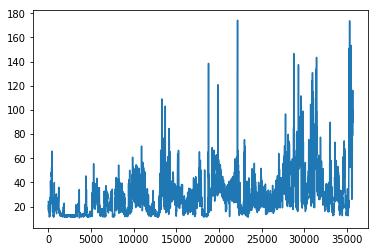

a grad norms [711.0793, 707.95044, 14.325505, 68.06079, 810.5215, 9.764536e-08, 0.00013175565, 9.483301e-08]
aloss nan closs 4.511943 vloss 48.60027
v grad norms [3.1805575, 2.138828, 3.2427263e-08, 0.16358137]
c grad norms [0.10060643, 0.45986408, 7.5461253e-07, 0.0015755281, 0.21828747]
m grad norms [506512280000.0, 3.808612, 6.465529e-08, 0.026497072, 506510570000.0]
 ep,  35710  avg frames 86.55
abs action (1,) 1.5646624565124512
max reward 2.0
a grad norms [773.12274, 775.16864, 13.365346, 112.92228, 845.73706, 9.589828e-08, 7.366747e-05, 5.8404712e-08]
aloss nan closs 4.5598755 vloss 51.236988
v grad norms [358882.88, 0.9736554, 3.2298036e-08, 359546.38]
c grad norms [0.18429579, 0.47155157, 7.563321e-07, 0.0012908028, 0.09792715]
m grad norms [401887950000.0, 4.8367624, 6.46401e-08, 0.00440698, 401888900000.0]
 ep,  35720  avg frames 52.15
abs action (1,) 0.5236971974372864
max reward 2.0
a grad norms [832.4331, 858.0544, 14.083735, 181.57797, 848.0309, 9.545587e-08, 9.479604e-0

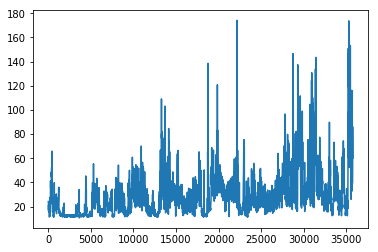

a grad norms [963.05707, 995.79297, 14.177217, 314.05945, 889.46344, 9.50456e-08, 2.0736182e-07, 7.6032386e-10]
aloss nan closs 3.6653953 vloss 48.101295
v grad norms [0.58203125, 0.07095299, 3.2519385e-08, 0.5807044]
c grad norms [0.10170268, 0.45079708, 7.6319446e-07, 0.003050385, 0.4102703]
m grad norms [32729930000.0, 4.866777, 6.439759e-08, 0.009054496, 32730292000.0]
 ep,  35810  avg frames 58.8
abs action (1,) 0.51884925365448
max reward 2.0
a grad norms [807.73785, 788.59015, 15.226811, 123.28083, 880.82825, 9.552691e-08, 6.981527e-05, 6.631543e-09]
aloss nan closs 2.8835557 vloss 52.28649
v grad norms [4.3268013, 3.385417, 3.2359058e-08, 0.10378313]
c grad norms [0.039691195, 0.35560274, 7.660171e-07, 0.0032515263, 0.37045547]
m grad norms [6123241300000.0, 3.989683, 6.429159e-08, 0.24134612, 6123234500000.0]
 ep,  35820  avg frames 61.55
abs action (1,) 1.5097484588623047
max reward 2.0
a grad norms [955.7732, 948.1665, 15.246513, 274.5805, 921.58325, 9.438938e-08, 1.7445218e

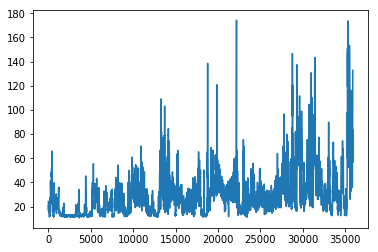

a grad norms [949.77106, 947.4854, 14.765826, 43.635902, 1132.3882, 9.575812e-08, 1.848042e-06, 3.3958028e-08]
aloss nan closs 2.8454556 vloss 42.68905
v grad norms [0.76769376, 0.4362255, 3.323075e-08, 0.1094757]
c grad norms [0.055188492, 0.311947, 7.7964563e-07, 0.0023273423, 0.1767705]
m grad norms [36625576000.0, 3.3383732, 6.405482e-08, 0.0054503814, 36625465000.0]
 ep,  35910  avg frames 89.9
abs action (1,) 2.0110177993774414
max reward 2.0
a grad norms [970.1003, 970.58075, 14.585175, 84.402954, 1117.1163, 9.557584e-08, 3.8390403e-06, 2.8492819e-08]
aloss nan closs 2.9938488 vloss 48.088825
v grad norms [0.485603, 1.0557986, 3.3009304e-08, 0.14583321]
c grad norms [0.053654183, 0.40810874, 7.805436e-07, 0.0037692674, 0.22425424]
m grad norms [40983425000.0, 5.019502, 6.4164105e-08, 0.0004927008, 40983515000.0]
 ep,  35920  avg frames 107.05
abs action (1,) 0.1889096051454544
max reward 2.0
a grad norms [1008.78595, 1004.6231, 15.816152, 74.40845, 1176.0596, 9.501853e-08, 1.043

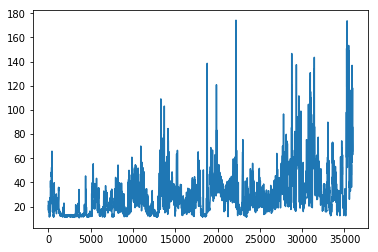

a grad norms [2009.6954, 1992.3385, 14.7873125, 1285.9458, 1265.6764, 9.4160974e-08, 6.819111e-05, 5.676726e-09]
aloss nan closs 2.5487409 vloss 43.341835
v grad norms [0.356107, 0.6759388, 3.354994e-08, 0.10298845]
c grad norms [0.09644685, 0.2959079, 7.830935e-07, 0.0041614897, 0.6704338]
m grad norms [3321101300000.0, 2.406738, 6.4333044e-08, 0.0036603902, 3321104400000.0]
 ep,  36010  avg frames 85.85
abs action (1,) 1.6824098825454712
max reward 2.0
a grad norms [1078.1191, 1071.3008, 15.689601, 70.645905, 1265.3021, 9.4378294e-08, 3.7009824e-05, 7.608474e-08]
aloss nan closs 2.1457105 vloss 46.21653
v grad norms [5.804004, 4.75698, 3.348315e-08, 0.08253119]
c grad norms [0.06145056, 0.21721667, 7.8533907e-07, 0.0018033516, 0.058175076]
m grad norms [227159030000.0, 1.6688505, 6.4181656e-08, 0.017505122, 227158740000.0]
 ep,  36020  avg frames 59.3
abs action (1,) 0.8519185781478882
max reward 2.0
a grad norms [1057.5708, 1044.0463, 15.426186, 105.01253, 1206.8998, 9.3745065e-08, 

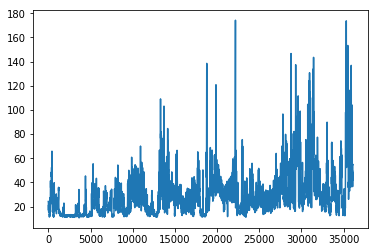

a grad norms [1048.3248, 1008.9375, 14.009285, 227.13068, 1085.4716, 8.8712504e-08, 1.7460842e-08, 6.90106e-10]
aloss nan closs 3.362728 vloss 51.33602
v grad norms [28474.4, 6.952814, 3.3079257e-08, 29065.162]
c grad norms [0.15078343, 0.4569709, 7.977328e-07, 0.0048692687, 0.8581529]
m grad norms [488854800000.0, 2.6962078, 6.441646e-08, 0.013643303, 488855670000.0]
 ep,  36110  avg frames 57.35
abs action (1,) 1.1847556829452515
max reward 2.0
a grad norms [970.73755, 950.1385, 13.782407, 171.38177, 1052.578, 8.868204e-08, 4.3068227e-05, 2.036012e-08]
aloss nan closs 2.62298 vloss 52.169453
v grad norms [3.8832817, 4.945641, 3.2719235e-08, 0.14611341]
c grad norms [0.060276933, 0.30418146, 8.003951e-07, 0.002246048, 0.13592853]
m grad norms [1966252500000.0, 1.6382171, 6.4517224e-08, 0.021656385, 1966252600000.0]
 ep,  36120  avg frames 70.7
abs action (1,) 0.8574972748756409
max reward 2.0
a grad norms [972.3748, 945.95264, 18.048166, 214.46045, 1022.9581, 9.024385e-08, 3.80613e-05

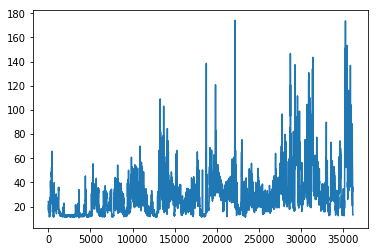

a grad norms [2086.176, 1959.9598, 14.296364, 2120.3252, 921.82837, 9.0912955e-08, 0.00042670572, 2.7694065e-07]
aloss nan closs 2.8737354 vloss 56.938797
v grad norms [3.4439232, 2.792635, 3.260492e-08, 0.059092905]
c grad norms [0.09553872, 0.20275539, 8.20751e-07, 0.00097084086, 0.58348244]
m grad norms [628417200000.0, 6.539364, 6.436079e-08, 0.010579709, 628420200000.0]
 ep,  36210  avg frames 12.9
abs action (1,) 2.2991371154785156
max reward 2.0
a grad norms [795.46783, 772.23846, 13.27608, 247.99648, 953.31934, 9.25048e-08, 0.0036999285, 2.2228225e-05]
aloss nan closs 2.7524192 vloss 47.923557
v grad norms [3.1470783, 4.0721526, 3.27181e-08, 0.10324479]
c grad norms [0.2528258, 0.27964962, 8.242217e-07, 0.00041240876, 0.0005209252]
m grad norms [2966434000000.0, 26.54529, 6.42397e-08, 0.06171455, 2966448500000.0]
 ep,  36220  avg frames 13.3
abs action (1,) 2.1811106204986572
max reward 2.0
a grad norms [958.36444, 916.608, 13.572368, 959.94794, 1382.9714, 9.188918e-08, 0.00048

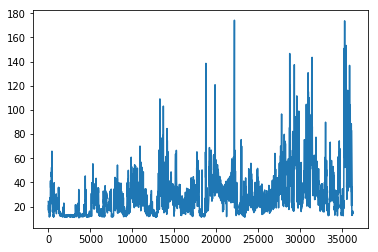

a grad norms [809.4155, 798.9864, 13.493885, 176.61234, 848.14734, 8.997981e-08, 0.00088116335, 1.9545475e-06]
aloss nan closs 2.8584821 vloss 46.500843
v grad norms [0.30681044, 0.6183099, 3.4229885e-08, 0.07612358]
c grad norms [0.05547501, 0.27095377, 8.429224e-07, 0.0011661676, 0.19654067]
m grad norms [26285885000.0, 4.2984056, 6.376144e-08, 0.03934251, 26285947000.0]
 ep,  36310  avg frames 13.9
abs action (1,) 2.316781997680664
max reward 2.0
a grad norms [930.9786, 896.1021, 15.541163, 283.24667, 890.76996, 8.904524e-08, 0.0005033021, 6.1675246e-07]
aloss nan closs 2.7156649 vloss 38.30641
v grad norms [0.5931452, 0.9578325, 3.4403083e-08, 0.13634223]
c grad norms [3343.0967, 0.20734772, 8.445284e-07, 0.0053001535, 5066.278]
m grad norms [63841900000.0, 5.352001, 6.389198e-08, 0.0009396993, 63841940000.0]
 ep,  36320  avg frames 13.6
abs action (1,) 2.371150493621826
max reward 2.0
a grad norms [846.14655, 811.26654, 15.649707, 314.99207, 896.407, 8.959979e-08, 0.00040954727, 4

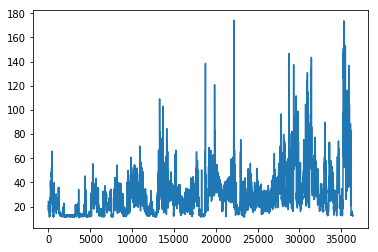

a grad norms [998.6412, 991.23236, 14.14507, 294.42554, 994.07196, 9.03702e-08, 0.0009883828, 0.0012972872]
aloss nan closs 2.4622433 vloss 47.16392
v grad norms [5.7818027, 0.05212, 3.415091e-08, 6.1536174]
c grad norms [2.560414, 0.14002131, 8.4838933e-07, 0.00089510577, 5.4387593]
m grad norms [72357760000.0, 2.7411106, 6.4232886e-08, 0.0012510217, 72357420000.0]
 ep,  36410  avg frames 12.15
abs action (1,) 2.6157102584838867
max reward 2.0
a grad norms [1079.0587, 1087.3995, 14.5844755, 301.2811, 1072.805, 9.156739e-08, 0.0008883143, 1.9174827e-06]
aloss nan closs 1.8306816 vloss 35.872906
v grad norms [0.32226822, 0.22063267, 3.4286845e-08, 0.024686428]
c grad norms [0.2394131, 0.0917145, 8.485435e-07, 0.00019634864, 0.095465206]
m grad norms [155514950000.0, 3.2414856, 6.433285e-08, 0.015528635, 155513700000.0]
 ep,  36420  avg frames 12.2
abs action (1,) 2.5602638721466064
max reward 2.0
a grad norms [984.6943, 984.90985, 14.396337, 178.23483, 1070.6002, 9.242921e-08, 0.0009858

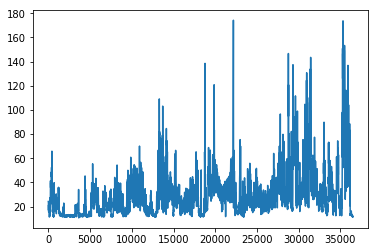

a grad norms [1467.3173, 1492.4374, 15.491832, 223.48001, 1632.2279, 9.722549e-08, 0.0034290587, 3.168763e-05]
aloss nan closs 2.2639103 vloss 33.064907
v grad norms [0.05482864, 0.023067286, 3.267638e-08, 0.026516331]
c grad norms [11.713092, 0.09538759, 8.5166204e-07, 0.0008558396, 19.988012]
m grad norms [568890800000.0, 4.6905804, 6.3503016e-08, 0.0039103352, 568892000000.0]
 ep,  36510  avg frames 11.95
abs action (1,) 2.555159330368042
max reward 2.0
a grad norms [1629.3195, 1627.2339, 15.257439, 131.72662, 1963.2495, 9.6939395e-08, 0.0010986597, 2.1644057e-06]
aloss nan closs 2.0087478 vloss 29.095888
v grad norms [0.030992249, 0.033125754, 3.234153e-08, 0.018583788]
c grad norms [1.3967134, 0.08064682, 8.523598e-07, 0.0007543185, 2.9335654]
m grad norms [1698596200.0, 1.2295521, 6.342381e-08, 0.0024274027, 1698576800.0]
 ep,  36520  avg frames 12.45
abs action (1,) 0.5449162425785552
max reward 2.0
a grad norms [1750.312, 1745.4839, 16.108366, 148.2496, 2088.5583, 9.447544e-08,

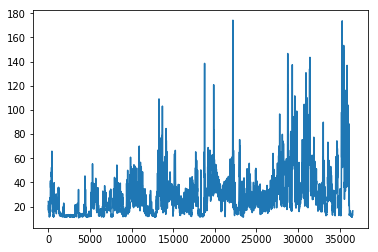

a grad norms [4877.2705, 3809.2998, 20.407892, 5342.4614, 2276.3147, 8.468186e-08, 0.026991772, 4.6807632e-05]
aloss nan closs 0.41059214 vloss 5.21643
v grad norms [0.14545338, 0.17234309, 3.467963e-08, 0.04598994]
c grad norms [2.121358, 0.014936143, 8.6677284e-07, 0.00011338505, 3.6881459]
m grad norms [29379494.0, 0.4399397, 6.298167e-08, 2.4651303e-05, 29378142.0]
 ep,  36610  avg frames 15.3
abs action (1,) 2.5735459327697754
max reward 2.0
a grad norms [1610.5289, 1598.0336, 8.911496, 109.02081, 1956.716, 8.425649e-08, 2.0607233e-06, 6.9567584e-08]
aloss nan closs 0.3444363 vloss 3.9767172
v grad norms [22.725456, 0.08550205, 3.4516297e-08, 20.91985]
c grad norms [0.40540102, 0.009980869, 8.6898973e-07, 2.5492462e-05, 0.77252716]
m grad norms [101505930.0, 0.040746205, 6.2920506e-08, 0.00038671392, 101505560.0]
 ep,  36620  avg frames 14.45
abs action (1,) 2.378736972808838
max reward 2.0
a grad norms [1597.7067, 1598.4696, 11.875936, 424.1675, 1706.1556, 8.466893e-08, 0.0012482

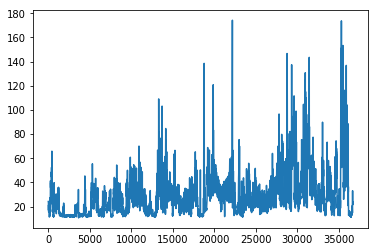

a grad norms [1634.8744, 1641.8668, 7.9593773, 27.11657, 2069.4578, 8.491123e-08, 7.380147e-05, 1.953383e-08]
aloss nan closs 0.40300903 vloss 2.5396109
v grad norms [0.014007402, 0.020562325, 3.574436e-08, 0.013069085]
c grad norms [0.0003250671, 0.00865296, 8.904736e-07, 2.8575674e-05, 0.009003274]
m grad norms [44349508.0, 0.024214735, 6.227906e-08, 0.0016757004, 44349180.0]
 ep,  36710  avg frames 21.85
abs action (1,) 2.464273452758789
max reward 2.0
a grad norms [2025.2969, 2014.0809, 13.336871, 57.10646, 2517.0388, 8.5213884e-08, 4.529816e-05, 1.4808275e-07]
aloss nan closs 0.39599398 vloss 3.8465981
v grad norms [0.02034633, 0.005806466, 3.570602e-08, 0.014532792]
c grad norms [0.178722, 0.008693947, 8.907702e-07, 6.446808e-05, 0.3828857]
m grad norms [64681108.0, 0.050625738, 6.2095324e-08, 0.00028696263, 64683332.0]
 ep,  36720  avg frames 21.95
abs action (1,) 2.6017210483551025
max reward 2.0
a grad norms [1900.652, 1892.4752, 7.9491925, 44.2007, 2427.4692, 8.4268e-08, 5.29

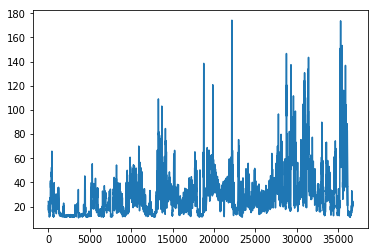

a grad norms [3859.5188, 3864.9968, 11.139665, 30.628323, 4953.243, 8.235819e-08, 2.7856975e-06, 5.778779e-09]
aloss nan closs 0.56734663 vloss 5.013144
v grad norms [10.225021, 0.009208751, 3.6254e-08, 10.434177]
c grad norms [0.0044599897, 0.00596228, 9.142866e-07, 1.324532e-05, 0.00020853525]
m grad norms [44466268.0, 0.040563393, 6.0822835e-08, 0.00034892373, 44467244.0]
 ep,  36810  avg frames 21.3
abs action (1,) 0.011950402135921159
max reward 2.0
a grad norms [4474.368, 4481.5283, 11.6662245, 40.933224, 5757.8745, 8.196064e-08, 4.1752854e-05, 8.9634504e-08]
aloss nan closs 0.44685787 vloss 5.630225
v grad norms [0.054711524, 0.027734809, 3.6302517e-08, 0.048437476]
c grad norms [0.0054832078, 0.0087686945, 9.1619285e-07, 2.351035e-05, 0.02473896]
m grad norms [220737830000.0, 0.05016246, 6.0614546e-08, 0.0006193304, 220738010000.0]
 ep,  36820  avg frames 19.2
abs action (1,) 1.5897586189887682
max reward 2.0
a grad norms [3474.5447, 3473.3057, 11.384254, 22.786785, 4463.552, 8

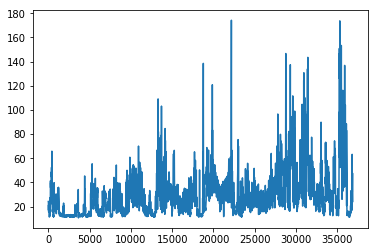

a grad norms [2364.2014, 2362.26, 12.97664, 67.38465, 2954.7766, 8.212004e-08, 4.242624e-06, 4.3967088e-09]
aloss nan closs 1.0097233 vloss 29.250603
v grad norms [3.9006138, 1.3024877, 3.8286405e-08, 2.1405263]
c grad norms [0.1789664, 0.054795768, 9.317453e-07, 0.00012919442, 0.10565314]
m grad norms [18323352000.0, 0.7686375, 6.010017e-08, 0.004224893, 18323352000.0]
 ep,  36910  avg frames 31.15
abs action (1,) 1.285647988319397
max reward 2.0
a grad norms [2436.0225, 2438.207, 12.135747, 60.790936, 3059.5005, 8.274756e-08, 1.7019924e-05, 4.6160434e-08]
aloss nan closs 0.9768184 vloss 23.986177
v grad norms [8.891953, 1.0007204, 3.8614292e-08, 9.08425]
c grad norms [0.8822286, 0.04655035, 9.3022226e-07, 0.000109546, 1.8737488]
m grad norms [8059293000.0, 0.25730821, 6.0207945e-08, 0.0018328996, 8059261000.0]
 ep,  36920  avg frames 32.6
abs action (1,) 1.3267334699630737
max reward 2.0
a grad norms [2471.462, 2481.9866, 13.863275, 129.99397, 2970.5134, 8.203505e-08, 5.6651876e-05, 

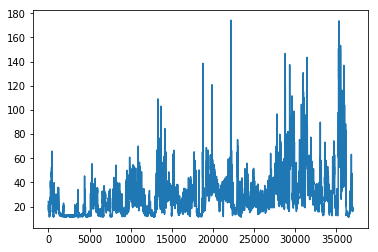

a grad norms [2686.68, 2767.503, 15.149661, 342.35114, 3067.6416, 7.9057635e-08, 1.2870753e-05, 1.1338528e-08]
aloss nan closs 1.5253478 vloss 22.369534
v grad norms [0.955946, 0.20977144, 3.935801e-08, 0.77668864]
c grad norms [370.46, 0.08286796, 9.494573e-07, 0.00022422976, 570.0186]
m grad norms [127339690.0, 0.3972235, 5.936941e-08, 0.00025084836, 127344830.0]
 ep,  37010  avg frames 20.25
abs action (1,) 2.234511375427246
max reward 2.0
a grad norms [2759.967, 2793.245, 15.446599, 104.14423, 3445.004, 7.8963716e-08, 8.480544e-05, 3.189344e-08]
aloss nan closs 1.3475373 vloss 22.40055
v grad norms [0.0522029, 0.075094886, 3.987971e-08, 0.012739337]
c grad norms [131.3427, 0.085160695, 9.5019817e-07, 0.0003713657, 205.43419]
m grad norms [379062680000.0, 0.18622418, 5.9356484e-08, 0.0035509823, 379062850000.0]
 ep,  37020  avg frames 21.9
abs action (1,) 2.521148443222046
max reward 2.0
a grad norms [2600.4395, 2598.4814, 13.973038, 99.64415, 3235.7979, 7.8893414e-08, 2.8348615e-05

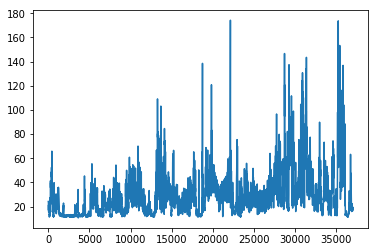

a grad norms [2862.294, 2867.7878, 15.397616, 121.21091, 3542.454, 7.843565e-08, 9.765454e-06, 3.7536365e-09]
aloss nan closs 1.454053 vloss 16.99439
v grad norms [5.2754803, 0.103565656, 4.033579e-08, 4.141623]
c grad norms [3556.2815, 0.06208631, 9.69759e-07, 0.00015277116, 5342.346]
m grad norms [41764663000.0, 0.0961915, 5.896273e-08, 0.0028580737, 41764643000.0]
 ep,  37110  avg frames 20.35
abs action (1,) 2.6112611293792725
max reward 2.0
a grad norms [2751.3953, 2753.0637, 13.222644, 100.05917, 3432.3982, 7.857533e-08, 3.539174e-05, 4.6259476e-09]
aloss nan closs 1.6490444 vloss 21.884844
v grad norms [0.47803235, 0.34313118, 3.9560913e-08, 0.32414177]
c grad norms [0.060709383, 0.08683685, 9.744184e-07, 7.786716e-05, 0.00467925]
m grad norms [47992830000.0, 0.1722034, 5.8818205e-08, 0.0066063204, 47992828000.0]
 ep,  37120  avg frames 23.15
abs action (1,) 2.616786241531372
max reward 2.0
a grad norms [71641020.0, 2833.242, 14.766998, 140.70319, 3472.4084, 7.866538e-08, 0.8864

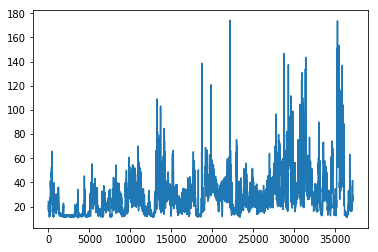

a grad norms [2383.8262, 2384.9036, 12.717365, 424.02917, 2632.1082, 7.8932224e-08, 8.266925e-06, 1.3701581e-09]
aloss nan closs 1.8128324 vloss 23.912186
v grad norms [3.4516563, 0.16553868, 4.098833e-08, 3.4683974]
c grad norms [0.044961747, 0.10796554, 1.0024918e-06, 0.00011908131, 0.034094002]
m grad norms [9109455000.0, 0.16541778, 5.8629883e-08, 0.0035516338, 9109433000.0]
 ep,  37210  avg frames 30.35
abs action (1,) 1.4987611770629883
max reward 2.0
a grad norms [2047.9869, 2051.0928, 11.556572, 101.307335, 2514.5576, 7.891009e-08, 1.601295e-07, 2.206593e-09]
aloss nan closs 1.8207998 vloss 20.616796
v grad norms [0.026369229, 0.05417277, 4.0691827e-08, 0.016531099]
c grad norms [0.019637957, 0.09248033, 1.0064015e-06, 0.00012813772, 0.045317557]
m grad norms [1578698600.0, 0.13933705, 5.858475e-08, 0.0011766753, 1578701800.0]
 ep,  37220  avg frames 34.4
abs action (1,) 1.4071743488311768
max reward 2.0
a grad norms [4537414.5, 2209.1821, 41.902393, 92.365135, 2560.192, 7.8904

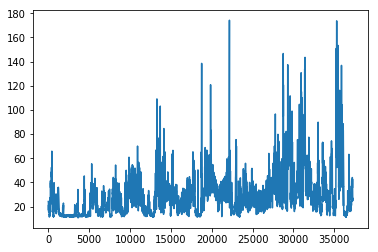

a grad norms [1803.749, 1810.161, 11.087875, 79.6796, 2227.4795, 7.8916834e-08, 1.2797068e-05, 2.8639204e-09]
aloss nan closs 1.0535506 vloss 12.834051
v grad norms [0.07654203, 0.07147973, 3.9751956e-08, 0.03904855]
c grad norms [44.356712, 0.049403086, 1.0373321e-06, 0.0001197753, 70.371025]
m grad norms [5982548000000.0, 0.084513485, 5.7938678e-08, 0.00849113, 5982546000000.0]
 ep,  37310  avg frames 30.85
abs action (1,) 0.8581280708312988
max reward 2.0
a grad norms [1803.3705, 1828.8109, 13.432141, 79.164734, 2229.373, 7.889007e-08, 5.055049e-05, 5.4249337e-08]
aloss nan closs 1.4582448 vloss 17.169197
v grad norms [0.9770301, 0.9409452, 3.9619604e-08, 0.11834782]
c grad norms [0.8687209, 0.068784475, 1.0383743e-06, 0.00025646607, 1.9474443]
m grad norms [2055838200000.0, 0.20102371, 5.7840854e-08, 0.12427113, 2055837000000.0]
 ep,  37320  avg frames 43.2
abs action (1,) 0.825115978717804
max reward 2.0
a grad norms [1987.9513, 2005.4235, 11.985065, 70.585594, 2463.8696, 7.889554

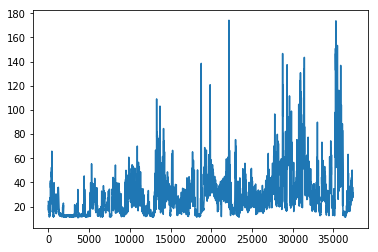

a grad norms [1996.1656, 2007.0936, 10.726265, 68.68193, 2480.4355, 8.013719e-08, 1.074182e-06, 4.7653224e-09]
aloss nan closs 1.1686206 vloss 8.700525
v grad norms [0.300261, 0.29351065, 3.719657e-08, 0.006500659]
c grad norms [4.3515315, 0.031635426, 1.0612272e-06, 4.0842948e-05, 5.748619]
m grad norms [1164768900.0, 0.04912846, 5.789496e-08, 0.00017976943, 1164762000.0]
 ep,  37410  avg frames 37.6
abs action (1,) 0.7529470324516296
max reward 2.0
a grad norms [2532.4014, 2536.155, 13.361716, 67.25306, 3175.418, 8.0347434e-08, 5.5676323e-05, 4.244987e-09]
aloss nan closs 1.3952241 vloss 14.355998
v grad norms [0.10034723, 0.1611393, 3.7181174e-08, 0.01652612]
c grad norms [41440.113, 0.05060692, 1.0631074e-06, 0.0005803387, 62210.473]
m grad norms [4373128000.0, 0.11552466, 5.782692e-08, 0.0015614517, 4373139500.0]
 ep,  37420  avg frames 50.4
abs action (1,) 0.9774435758590698
max reward 2.0
a grad norms [1966.2975, 1967.7999, 11.804393, 82.11951, 2422.7207, 8.04694e-08, 3.907087e-

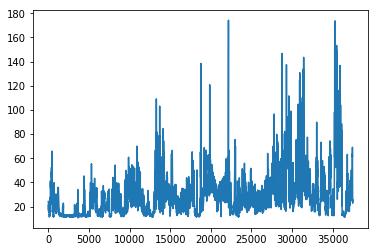

a grad norms [2013.9174, 2016.5453, 12.4462, 55.46267, 2508.2075, 7.90503e-08, 2.1493033e-06, 7.3692337e-09]
aloss nan closs 1.7176651 vloss 13.265463
v grad norms [1.8904172, 0.12697686, 3.7651755e-08, 2.092438]
c grad norms [353.54135, 0.08065312, 1.0907969e-06, 0.0002814806, 542.02356]
m grad norms [439604180000.0, 0.118742, 5.756486e-08, 0.1072101, 439603800000.0]
 ep,  37510  avg frames 25.55
abs action (1,) 1.326749563217163
max reward 2.0
a grad norms [1942.8242, 1955.34, 11.939464, 61.191277, 2417.3408, 7.9023e-08, 1.184743e-06, 9.403098e-09]
aloss nan closs 1.7381881 vloss 18.146223
v grad norms [9.063542, 0.5043547, 3.7382083e-08, 7.0109725]
c grad norms [0.9285804, 0.11375764, 1.0975306e-06, 0.00022925396, 2.2454433]
m grad norms [1807755000000000.0, 0.11265808, 5.7532187e-08, 0.40587366, 1807755000000000.0]
 ep,  37520  avg frames 23.15
abs action (1,) 1.3782988786697388
max reward 2.0
a grad norms [1586.2452, 1608.7681, 12.05288, 84.4359, 1933.4928, 7.906529e-08, 1.3013033

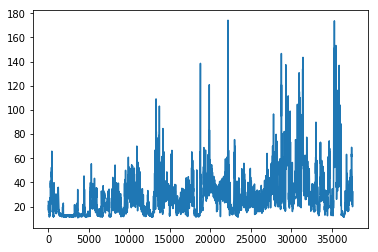

a grad norms [1544.507, 1551.2775, 10.705467, 53.552322, 1906.6248, 7.9921925e-08, 6.9276225e-06, 1.8657873e-09]
aloss nan closs 1.8959452 vloss 19.364109
v grad norms [1174554.4, 0.9044159, 3.686551e-08, 1174414.1]
c grad norms [0.089908935, 0.13402408, 1.127266e-06, 0.00011364313, 0.009968757]
m grad norms [246611560000.0, 0.1123603, 5.700083e-08, 0.003230666, 246611500000.0]
 ep,  37610  avg frames 29.55
abs action (1,) 2.623541831970215
max reward 2.0
a grad norms [1670.8037, 1671.4468, 11.622022, 49.262024, 2065.9558, 7.999065e-08, 1.1967306e-05, 1.73384e-08]
aloss nan closs 1.6694369 vloss 15.994994
v grad norms [142040.7, 0.30439103, 3.6268464e-08, 142335.19]
c grad norms [105602.32, 0.100372456, 1.12951e-06, 6.7876514e-05, 158182.14]
m grad norms [19393138000000.0, 0.073869735, 5.6927888e-08, 0.029193057, 19393134000000.0]
 ep,  37620  avg frames 28.2
abs action (1,) 2.5607972145080566
max reward 2.0
a grad norms [1847.7295, 1846.3304, 10.788144, 75.040924, 2282.7004, 8.02147e-

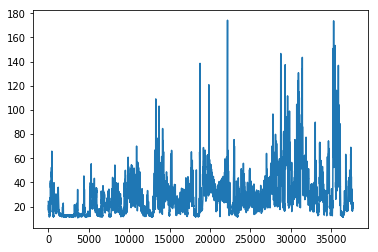

a grad norms [2105.1782, 2107.2961, 12.236819, 53.997, 2631.695, 8.1040746e-08, 1.8073104e-05, 5.007756e-09]
aloss nan closs 2.0151079 vloss 14.165174
v grad norms [0.42803326, 0.2216928, 3.5587256e-08, 0.2762674]
c grad norms [0.38561806, 0.07956274, 1.1345273e-06, 0.00018012279, 0.9321379]
m grad norms [367607150000.0, 0.07387047, 5.7132652e-08, 0.0022892104, 367606920000.0]
 ep,  37710  avg frames 21.0
abs action (1,) 2.6148695945739746
max reward 2.0
a grad norms [2272.6138, 2286.7996, 12.680195, 42.75734, 2873.073, 8.071785e-08, 2.7511627e-05, 4.545694e-09]
aloss nan closs 1.8714985 vloss 13.408651
v grad norms [4.4418883, 0.54900473, 3.523007e-08, 2.7277155]
c grad norms [17881.664, 0.08280348, 1.1340817e-06, 0.0023684378, 26901.422]
m grad norms [2784385300.0, 0.076188646, 5.7307517e-08, 0.0022260745, 2784378400.0]
 ep,  37720  avg frames 20.4
abs action (1,) 2.614185094833374
max reward 2.0
a grad norms [2082.6277, 2082.0657, 16.120237, 68.26067, 2571.765, 8.0937355e-08, 8.1375

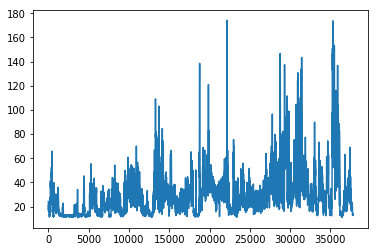

a grad norms [2214.8113, 2221.259, 11.099533, 168.08061, 2676.1047, 8.196992e-08, 0.0006983406, 3.4806478e-06]
aloss nan closs 1.9011707 vloss 14.981921
v grad norms [1.15001, 0.14512432, 3.422475e-08, 1.3518448]
c grad norms [0.017541744, 0.071936056, 1.1563428e-06, 0.00015272792, 0.038078632]
m grad norms [2983732200000.0, 0.427066, 5.7649945e-08, 0.0037622123, 2983731700000.0]
 ep,  37810  avg frames 13.8
abs action (1,) 2.641892910003662
max reward 2.0
a grad norms [2283.5627, 2288.598, 11.14844, 90.29181, 2840.3247, 8.206478e-08, 0.0007988857, 2.84009e-06]
aloss nan closs 1.5859089 vloss 13.682416
v grad norms [0.044720173, 0.030626424, 3.4695727e-08, 0.053439524]
c grad norms [0.00752257, 0.053166136, 1.1580815e-06, 0.00012875527, 0.04262198]
m grad norms [237899370000.0, 0.16553606, 5.756664e-08, 0.19751756, 237899890000.0]
 ep,  37820  avg frames 14.05
abs action (1,) 2.6305365562438965
max reward 2.0
a grad norms [2096.7236, 2055.2588, 11.100007, 64.84573, 2581.0898, 8.3219085

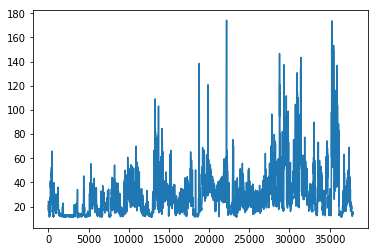

a grad norms [1881.4073, 1884.6151, 9.323346, 75.085175, 2353.6492, 8.1741796e-08, 0.00030135855, 2.7294382e-07]
aloss nan closs 1.3159708 vloss 7.4669533
v grad norms [0.12399609, 0.10114225, 3.2372004e-08, 0.0043798005]
c grad norms [0.0046845716, 0.037329968, 1.1897292e-06, 5.176541e-05, 0.05031934]
m grad norms [45116600000.0, 0.18210162, 5.7450986e-08, 0.00091501465, 45116576000.0]
 ep,  37910  avg frames 14.7
abs action (1,) 2.1922194957733154
max reward 2.0
a grad norms [1736.5316, 1739.2284, 9.569623, 55.943718, 2180.9685, 8.090291e-08, 0.00032488364, 9.572291e-07]
aloss nan closs 1.2278907 vloss 8.706012
v grad norms [0.22767957, 0.09556639, 3.2423642e-08, 0.34860623]
c grad norms [0.0072187316, 0.027191825, 1.1908601e-06, 4.065917e-05, 0.06417702]
m grad norms [182607410000.0, 0.123342425, 5.745487e-08, 0.027735269, 182607200000.0]
 ep,  37920  avg frames 14.7
abs action (1,) 1.9638340473175049
max reward 2.0
a grad norms [1471.0171, 1472.2163, 9.701771, 104.68742, 1785.529, 

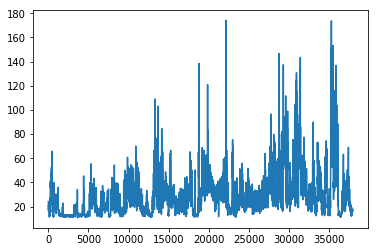

a grad norms [647.4479, 651.03094, 10.198131, 75.616936, 737.569, 7.9285265e-08, 2.4078457e-05, 7.923808e-09]
aloss nan closs 0.77035177 vloss 2.9430413
v grad norms [1.7944207, 0.0741994, 3.142025e-08, 2.189999]
c grad norms [332.5339, 0.021055082, 1.1963162e-06, 4.2079784e-05, 505.43063]
m grad norms [930641600.0, 0.08005359, 5.6894198e-08, 0.0005697968, 930637800.0]
 ep,  38010  avg frames 17.55
abs action (1,) 2.597744941711426
max reward 2.0
a grad norms [742.0125, 742.3213, 9.221972, 126.89369, 810.1753, 7.897516e-08, 1.1222677e-05, 3.911759e-09]
aloss nan closs 0.54028404 vloss 2.8258536
v grad norms [3.7800522, 0.043333456, 3.142243e-08, 4.246738]
c grad norms [0.07050866, 0.012615963, 1.2000131e-06, 1.6768185e-05, 0.19871967]
m grad norms [1752.4484, 0.03982621, 5.677354e-08, 1.8507957e-05, 1751.4409]
 ep,  38020  avg frames 17.15
abs action (1,) 2.565300941467285
max reward 2.0
a grad norms [802.2185, 808.17194, 8.427436, 123.1483, 891.10657, 7.871856e-08, 2.4632411e-06, 2.17

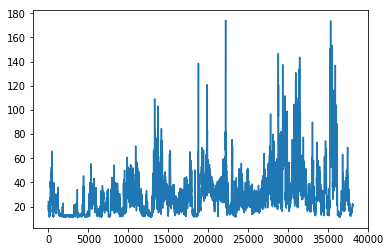

a grad norms [937.0433, 935.12506, 8.959073, 29.388145, 1149.7195, 7.873214e-08, 2.7814028e-06, 2.4265658e-09]
aloss nan closs 0.39986622 vloss 2.3134801
v grad norms [0.15476893, 0.015379827, 3.189927e-08, 0.14544506]
c grad norms [0.0965113, 0.01058058, 1.2183428e-06, 6.358878e-05, 0.24221903]
m grad norms [495186430.0, 0.041909005, 5.5857956e-08, 0.00040586595, 495182620.0]
 ep,  38110  avg frames 21.75
abs action (1,) 2.274409294128418
max reward 2.0
a grad norms [992.80005, 992.00433, 7.710687, 29.109755, 1227.2808, 7.872425e-08, 5.9427228e-05, 8.746878e-09]
aloss nan closs 0.45875955 vloss 2.0920155
v grad norms [0.052295882, 0.008364796, 3.2302456e-08, 0.055341557]
c grad norms [0.003840627, 0.009988551, 1.2234723e-06, 1.9872517e-05, 0.025631936]
m grad norms [15407247000.0, 0.03210112, 5.5687988e-08, 0.00060826144, 15407260000.0]
 ep,  38120  avg frames 21.7
abs action (1,) 1.99208664894104
max reward 2.0
a grad norms [1098.8441, 1100.192, 8.802383, 26.306662, 1364.2607, 7.8789

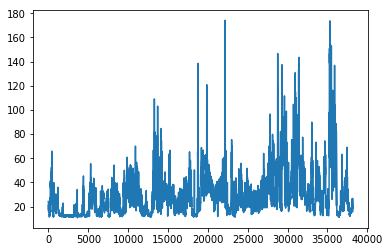

a grad norms [4339.443, 4338.26, 9.958127, 27.825024, 5597.815, 7.876773e-08, 2.3312205e-06, 1.6962752e-09]
aloss nan closs 0.3038789 vloss 2.1098711
v grad norms [9839.563, 0.0021254097, 3.217868e-08, 9832.985]
c grad norms [0.0071548754, 0.009139206, 1.2458139e-06, 3.9850154e-05, 0.029848376]
m grad norms [5006489000.0, 0.03760239, 5.540933e-08, 0.00041758272, 5006492700.0]
 ep,  38210  avg frames 20.55
abs action (1,) 1.3018912076950073
max reward 2.0
a grad norms [4622.44, 4626.758, 10.86934, 23.599648, 5973.2026, 7.882338e-08, 6.8862105e-06, 3.2290863e-09]
aloss nan closs 0.3958131 vloss 3.6765358
v grad norms [0.42659378, 0.008246168, 3.273257e-08, 0.38276687]
c grad norms [0.0008610767, 0.010553258, 1.2506284e-06, 5.6659646e-05, 0.018761588]
m grad norms [3751187200.0, 0.054165173, 5.5506234e-08, 0.0016470064, 3751168800.0]
 ep,  38220  avg frames 23.05
abs action (1,) 0.08253818273404422
max reward 2.0
a grad norms [5388.0063, 5386.9204, 13.507535, 24.184626, 6946.1196, 7.88910

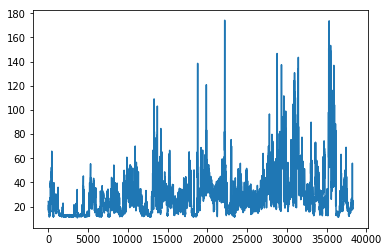

a grad norms [3454.2576, 3469.879, 14.29248, 36.131695, 4415.493, 7.867676e-08, 0.00041289933, 2.9399192e-07]
aloss nan closs 0.5137377 vloss 12.000632
v grad norms [0.1863826, 0.14240195, 3.3842465e-08, 0.04440805]
c grad norms [0.0038148495, 0.017090023, 1.2689344e-06, 6.141607e-05, 0.008283709]
m grad norms [2330647000.0, 0.21381474, 5.5052308e-08, 0.00015074521, 2330625800.0]
 ep,  38310  avg frames 19.35
abs action (1,) 0.6179542833804995
max reward 2.0
a grad norms [4028.3066, 4031.9377, 14.812352, 172.3667, 5014.5205, 7.8655724e-08, 1.9561508e-05, 5.873006e-10]
aloss nan closs 0.54238015 vloss 11.131799
v grad norms [0.8147338, 0.058823142, 3.3482255e-08, 0.7132562]
c grad norms [0.0028943357, 0.019816471, 1.2689586e-06, 8.682575e-05, 0.042031597]
m grad norms [16773094000.0, 0.25382093, 5.4987765e-08, 0.0004107743, 16773079000.0]
 ep,  38320  avg frames 20.4
abs action (1,) 2.4861438274383545
max reward 2.0
a grad norms [4537.206, 4552.1123, 16.612665, 854.7865, 5016.9395, 7.86

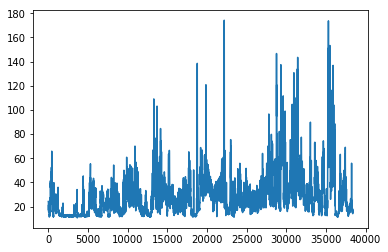

a grad norms [4062.954, 4062.6973, 10.303863, 40.42043, 5214.0767, 7.829971e-08, 7.3974647e-06, 6.6415287e-09]
aloss nan closs 0.8630522 vloss 6.4412994
v grad norms [0.27750304, 0.28174344, 3.396882e-08, 0.009563102]
c grad norms [0.0076740184, 0.03534724, 1.2863487e-06, 6.907389e-05, 0.01676323]
m grad norms [335237920.0, 0.18763782, 5.4787833e-08, 0.0008522114, 335244400.0]
 ep,  38410  avg frames 16.65
abs action (1,) 2.6561734676361084
max reward 2.0
a grad norms [3704.8987, 3704.4385, 15.9316025, 34.936523, 4725.4053, 7.8358646e-08, 2.590548e-05, 8.090523e-09]
aloss nan closs 0.96414804 vloss 15.031054
v grad norms [0.11003173, 0.102369376, 3.363456e-08, 0.06165779]
c grad norms [158.50427, 0.050979186, 1.2905874e-06, 0.00082385173, 244.57068]
m grad norms [11808050000.0, 0.29294917, 5.482282e-08, 0.0003844154, 11808067000.0]
 ep,  38420  avg frames 19.2
abs action (1,) 0.9955613654930747
max reward 2.0
a grad norms [3331.8552, 3334.955, 13.993812, 37.31619, 4244.882, 7.8376935e-

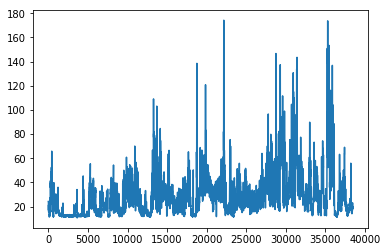

a grad norms [3549.2803, 3546.2097, 19.105135, 57.255474, 4489.162, 7.9425455e-08, 1.1544028e-05, 3.0862475e-09]
aloss nan closs 1.23429 vloss 13.898174
v grad norms [0.0413591, 0.027812824, 3.397115e-08, 0.058434132]
c grad norms [0.014241489, 0.06328305, 1.3169201e-06, 7.955921e-05, 0.03249482]
m grad norms [6792219000.0, 0.2428328, 5.4555883e-08, 0.0005612941, 6792241000.0]
 ep,  38510  avg frames 20.85
abs action (1,) 0.06440205971312433
max reward 2.0
a grad norms [3337.722, 3338.051, 15.496983, 70.95706, 4211.886, 7.9694615e-08, 2.8992774e-06, 3.0374643e-09]
aloss nan closs 1.0860827 vloss 12.296892
v grad norms [2.5960114, 0.07202321, 3.3976974e-08, 2.5989459]
c grad norms [52.946884, 0.053604897, 1.3210688e-06, 0.00026120193, 83.78326]
m grad norms [5175812600.0, 0.21286327, 5.4511716e-08, 0.0021337448, 5175807000.0]
 ep,  38520  avg frames 21.55
abs action (1,) 2.653825283050537
max reward 2.0
a grad norms [3440.0684, 3436.2102, 11.990082, 60.669083, 4366.055, 7.991326e-08, 1.

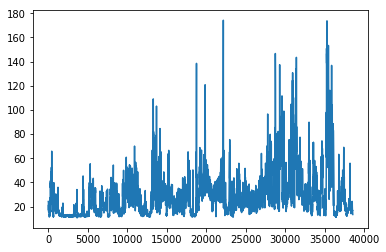

a grad norms [4249.038, 4252.282, 15.715241, 103.50937, 5395.8804, 8.2062066e-08, 0.0003098931, 9.470412e-07]
aloss nan closs 1.291676 vloss 13.133387
v grad norms [0.03961278, 0.05923975, 3.2715036e-08, 0.015076128]
c grad norms [4.8206873, 0.051853467, 1.3423602e-06, 7.505735e-05, 8.467202]
m grad norms [4041981200.0, 0.49810007, 5.3901065e-08, 0.00055961224, 4041959400.0]
 ep,  38610  avg frames 13.45
abs action (1,) 0.5548850731900222
max reward 2.0
a grad norms [3476.551, 3476.6172, 16.680359, 60.36982, 4420.433, 8.278246e-08, 0.000102210295, 6.5997355e-08]
aloss nan closs 1.580494 vloss 14.597559
v grad norms [0.060699284, 0.03759013, 3.2713288e-08, 0.046620414]
c grad norms [792.95776, 0.06849252, 1.3483203e-06, 0.00015336987, 1205.1508]
m grad norms [2433134300.0, 0.36562744, 5.3780976e-08, 0.00063476106, 2433132500.0]
 ep,  38620  avg frames 13.15
abs action (1,) 2.6593377590179443
max reward 2.0
a grad norms [3533.8904, 3535.4668, 15.320445, 439.81906, 4122.1475, 8.241479e-08

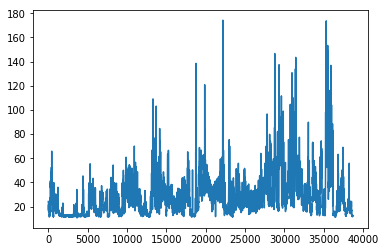

a grad norms [4500.7505, 4500.024, 11.408711, 64.83123, 5795.1245, 8.456166e-08, 9.321075e-05, 1.3682649e-08]
aloss nan closs 0.8271135 vloss 5.388884
v grad norms [2.5988123, 0.05207364, 3.3153043e-08, 2.9427192]
c grad norms [0.12861674, 0.027370391, 1.3770708e-06, 3.903429e-05, 0.38183555]
m grad norms [43829244000.0, 0.1257037, 5.392583e-08, 0.00088002, 43829244000.0]
 ep,  38710  avg frames 12.85
abs action (1,) 2.681057929992676
max reward 2.0
a grad norms [5102.834, 5090.2954, 11.744622, 96.494705, 6541.423, 8.581663e-08, 0.00018237975, 1.9247311e-07]
aloss nan closs 0.64645743 vloss 3.0293334
v grad norms [1.1889734, 0.048456326, 3.354436e-08, 0.9197081]
c grad norms [0.0054421956, 0.018774264, 1.3804807e-06, 1.5680867e-05, 0.047411755]
m grad norms [1095070800.0, 0.11054865, 5.3909584e-08, 0.00035794417, 1095061900.0]
 ep,  38720  avg frames 12.15
abs action (1,) 2.6792938709259033
max reward 2.0
a grad norms [6149.713, 6146.7954, 9.471574, 49.84692, 7973.2734, 8.6111946e-08, 

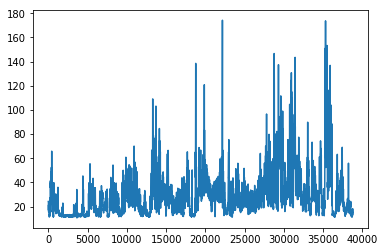

a grad norms [1367.0878, 1367.3575, 10.796353, 15.821041, 1711.1532, 8.9681755e-08, 2.600762e-06, 2.4923896e-09]
aloss nan closs 0.85256535 vloss 7.529916
v grad norms [0.21310592, 0.032184098, 3.3222054e-08, 0.22128232]
c grad norms [0.0029519731, 0.025383519, 1.4143346e-06, 3.1630363e-05, 0.022075454]
m grad norms [143061170000.0, 0.115114026, 5.3641404e-08, 0.003949179, 143061160000.0]
 ep,  38810  avg frames 15.3
abs action (1,) 2.7023141384124756
max reward 2.0
a grad norms [779.83813, 780.06195, 8.974105, 17.63899, 950.6876, 8.9307456e-08, 1.0763084e-06, 6.5618475e-09]
aloss nan closs 0.6487777 vloss 4.7164044
v grad norms [0.0073923543, 0.0024967727, 3.3372213e-08, 0.0024047021]
c grad norms [0.002640894, 0.018724715, 1.4188354e-06, 2.5092457e-05, 0.011454486]
m grad norms [4828771000.0, 0.10830235, 5.3565568e-08, 0.0006837227, 4828772000.0]
 ep,  38820  avg frames 13.5
abs action (1,) 2.692296266555786
max reward 2.0
a grad norms [615.05536, 615.2524, 8.655759, 38.863194, 717.9

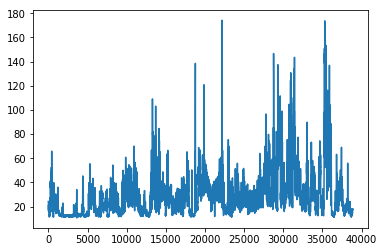

a grad norms [477.3575, 477.85962, 8.127892, 13.934934, 563.0884, 8.686796e-08, 2.7425865e-05, 7.1217756e-09]
aloss nan closs 0.5575404 vloss 2.6207097
v grad norms [0.5040018, 0.01742258, 3.238019e-08, 0.39020082]
c grad norms [0.0022132914, 0.013801987, 1.4460774e-06, 1.8403516e-05, 0.008424305]
m grad norms [2070628900000.0, 0.07732767, 5.296309e-08, 0.00093922316, 2070629400000.0]
 ep,  38910  avg frames 17.2
abs action (1,) 2.6984667778015137
max reward 2.0
a grad norms [671.2349, 671.4399, 5.876122, 35.52069, 797.54535, 8.655752e-08, 0.00011101778, 4.0429125e-08]
aloss nan closs 0.44788098 vloss 3.4037614
v grad norms [1.0493432, 0.004212715, 3.243214e-08, 1.0030667]
c grad norms [0.0015270896, 0.010550182, 1.4489168e-06, 1.5358046e-05, 0.007586587]
m grad norms [57535267000.0, 0.09857228, 5.3057672e-08, 0.0010352915, 57535330000.0]
 ep,  38920  avg frames 23.0
abs action (1,) 0.6089334062834896
max reward 2.0
a grad norms [496.78564, 497.17404, 12.045464, 52.945087, 536.9116, 8.

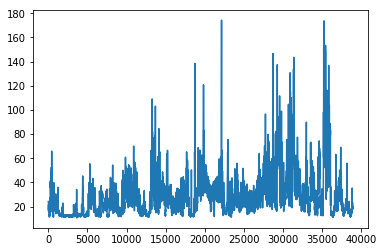

a grad norms [493.25668, 493.41116, 8.44842, 34.07214, 563.6065, 8.914612e-08, 3.427359e-06, 2.6979443e-09]
aloss nan closs 0.58537745 vloss 4.5802665
v grad norms [0.029195452, 0.0011127186, 3.2283086e-08, 0.039170936]
c grad norms [0.11806222, 0.01671889, 1.4739998e-06, 1.4829086e-05, 0.28541306]
m grad norms [40271890000.0, 0.08840262, 5.345124e-08, 0.00032871484, 40271884000.0]
 ep,  39010  avg frames 22.5
abs action (1,) 2.6741855144500732
max reward 2.0
a grad norms [377.9215, 378.65427, 7.7032075, 23.071022, 428.93832, 9.004637e-08, 1.4746644e-05, 3.0749232e-09]
aloss nan closs 0.4715904 vloss 2.8608928
v grad norms [0.16790621, 0.015950466, 3.2111583e-08, 0.20837076]
c grad norms [0.0298386, 0.012602212, 1.4774237e-06, 2.1757389e-05, 0.11142957]
m grad norms [22507198000.0, 0.09443402, 5.3442196e-08, 0.0009065484, 22507231000.0]
 ep,  39020  avg frames 21.75
abs action (1,) 2.6802053451538086
max reward 2.0
a grad norms [865.0887, 865.3293, 10.854274, 198.71925, 870.6001, 9.085

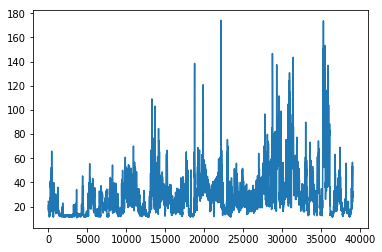

a grad norms [432.85196, 432.9633, 13.444328, 60.08498, 447.17383, 8.7116014e-08, 1.2534788e-05, 3.2453586e-09]
aloss nan closs 2.5864806 vloss 28.415071
v grad norms [1.4159908, 1.7331666, 3.4100818e-08, 0.034765866]
c grad norms [238585.92, 0.15066782, 1.4937845e-06, 0.00016380928, 358199.78]
m grad norms [27725414000.0, 0.54189104, 5.3462042e-08, 0.0048369872, 27725564000.0]
 ep,  39110  avg frames 25.3
abs action (1,) 2.6840569972991943
max reward 2.0
a grad norms [523.0379, 522.8913, 12.636467, 76.691956, 541.3772, 8.682262e-08, 3.0904548e-06, 1.0950695e-09]
aloss nan closs 1.2522988 vloss 14.326394
v grad norms [0.08825139, 0.10059309, 3.4470315e-08, 0.022322768]
c grad norms [0.018026689, 0.05099873, 1.4930157e-06, 7.710084e-05, 0.10685942]
m grad norms [4551682600.0, 0.18648262, 5.3416922e-08, 0.0031490568, 4551651300.0]
 ep,  39120  avg frames 24.75
abs action (1,) 2.6762726306915283
max reward 2.0
a grad norms [465.78244, 466.5393, 11.4906225, 162.18492, 398.76376, 8.611524e-

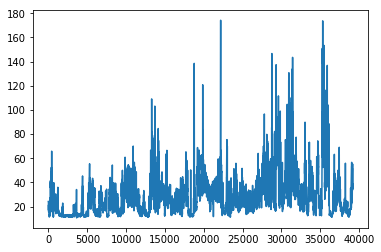

a grad norms [751.4302, 755.85333, 13.10892, 279.89706, 636.0543, 8.8376964e-08, 7.229176e-05, 3.6810846e-08]
aloss nan closs 2.6796215 vloss 17.626528
v grad norms [91198630000.0, 1.2731038, 3.516084e-08, 91198120000.0]
c grad norms [0.10576432, 0.22164229, 1.5327884e-06, 0.00023562922, 0.27414122]
m grad norms [43650000000.0, 0.53820837, 5.365412e-08, 0.0012192711, 43650028000.0]
 ep,  39210  avg frames 28.95
abs action (1,) 2.6467671394348145
max reward 2.0
a grad norms [705.8743, 706.2381, 12.685859, 65.55013, 799.55194, 8.789407e-08, 0.0002409154, 2.6461058e-07]
aloss nan closs 2.2028792 vloss 14.44482
v grad norms [2.1706111, 0.106624395, 3.5177646e-08, 2.5663853]
c grad norms [0.36005232, 0.11895144, 1.5372049e-06, 0.00022527397, 1.178322]
m grad norms [13477948000.0, 0.7532628, 5.3674015e-08, 0.0040236088, 13477974000.0]
 ep,  39220  avg frames 19.4
abs action (1,) 2.6740314960479736
max reward 2.0
a grad norms [872.0872, 871.9711, 12.886762, 79.42648, 1001.9346, 8.56982e-08, 0

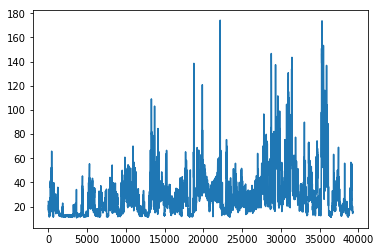

a grad norms [810.79083, 810.5524, 12.979233, 63.214443, 937.5911, 8.7674664e-08, 5.367401e-05, 8.288694e-08]
aloss nan closs 2.1884499 vloss 13.09066
v grad norms [307639.28, 0.24886894, 3.3622033e-08, 308018.47]
c grad norms [808.3383, 0.13538891, 1.5618722e-06, 0.00019387795, 1185.9479]
m grad norms [7379057000.0, 0.43274406, 5.4353166e-08, 0.0009477266, 7379054600.0]
 ep,  39310  avg frames 14.5
abs action (1,) 2.673630475997925
max reward 2.0
a grad norms [867.21954, 867.42676, 13.9889555, 60.26993, 1005.946, 8.849096e-08, 3.1017415e-05, 2.992437e-08]
aloss nan closs 2.3136764 vloss 14.965757
v grad norms [945.10626, 0.40626475, 3.3925165e-08, 953.5491]
c grad norms [0.24029525, 0.1448549, 1.5666195e-06, 0.00026039683, 0.8246584]
m grad norms [43322634000.0, 0.6107583, 5.4332173e-08, 0.0018264969, 43322690000.0]
 ep,  39320  avg frames 13.35
abs action (1,) 2.6722412109375
max reward 2.0
a grad norms [647.9024, 648.3643, 15.745552, 45.332073, 737.44183, 8.882256e-08, 0.0012746803,

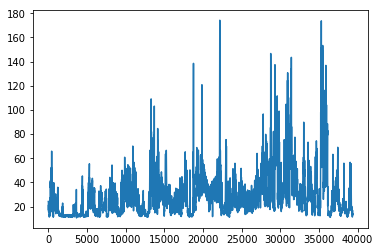

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-c7b89ab0e622>", line 190, in <module>
    feed_dict = feed_dict
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 900, in run
    run_metadata_ptr)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1135, in _run
    feed_dict_tensor, options, run_metadata)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1316, in _do_run
    run_metadata)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1322, in _do_call
    return fn(*args)
  File "/anaconda3/envs/py35/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1307, in _run_fn
    options, feed_dict

KeyboardInterrupt: 

In [11]:
if trained:
    try:
        saver.restore(sess, tffile)
        with open(obj_fname, "rb") as f:
            ah, sh, shraw, rh, rdecayedh, maskh, ep, globalframes = pickle.load(f)
        print('restored from save file')
    except:
        print('no save file detected')
        trained = 0
MAX_SEQ_LEN = 5000
for ep in range(ep, 10000000):
    if ep % 100 == 0 and trained and ep > 0:
        save_path = saver.save(sess, tffile)
        print('saved at epoch', ep)
        with open(obj_fname,"wb") as f:
            pickle.dump(
                [ah[-1000:], sh[-1000:], shraw[-1000:],
                 rh[-1000:], rdecayedh[-1000:], maskh[-1000:], ep, globalframes
                ], f)
    trained = 1
    ongoing = 1
    
    an, sn, snraw, rn, rdecayedn, maskn = [
        np.zeros((0, i)) for i in [N_ACT, INPUT_UNITS, N_OBS, 1, 1, 1]]
    frame = 0
    score = 0
    restart_delay = 5
    obs = env.reset()
    obsraw = obs
    snraw = np.concatenate((snraw, obs.reshape(1, -1)), 0)
    obs = np.concatenate((obs, np.zeros(N_ACT)))
    obs = np.concatenate((obs, np.zeros_like(obs)))
    obs_mat = np.concatenate((
        obs[None,:],np.zeros((NUM_HISTORY-1, N_STATE))), 0)
    rn = [0]
    done_ctr = 0
    sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
    step_num = 0
    step_shifted = -1
    show_shift = 0
    if np.random.rand() > .5:
        prob_random = PERCENT_CHOOSE_OPTIMAL#2#.95#1 - 1/np.sqrt(ep+1)
    else:
        prob_random = 2
    while 1:
        step_num += 1
        a = pi.act(obs_mat.flatten())
        if step_shifted == -1: #always act on your own
            shifted = 1
            if np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                a = np.random.randn(*a.shape)*.01
            elif np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                a = a + np.random.randn(*a.shape) * .5
                #a = a + np.random.randn(*a.shape)/np.sqrt(np.sqrt(ep + 2))*4
            elif np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2
                if np.random.rand() > .5:
                    a = a + impact
                else:
                    a = a - impact
            elif np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                impact = np.random.binomial(size=a.shape, n=1, p= 0.5) * 2 - 1
                a = a + impact
            elif np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                a = a * .5
            elif np.random.rand() > prob_random and RANDOM_STYLE_COMPLEX:
                a = a * 2
            elif np.random.rand() > prob_random and not RANDOM_STYLE_COMPLEX:
                a = (np.random.binomial(size=a.shape, n=1, p= 0.5) * 2 - 1
                    ) * np.random.randn()
            else:
                shifted = 0
            if shifted:
                step_shifted = step_num
        an = np.concatenate((an, a[None,:]), 0)
        snraw = np.concatenate((snraw, obsraw[None,:]), 0)
        last_obs = obs
#         last_obsraw = obsraw
        obs, r, done, _ = env.step(a)
        obsraw = obs
        r = r + 1 * REWARD_MULT

        obs_mat = accumulate_state(
            obs, a, obs_mat, STATE_DECAY, style = 'np')
        
        rn.append(r)
        sn = np.concatenate((sn, obs_mat.reshape(1, -1)), 0)
        score += r
        frame += 1
        still_open = env.render("human")
        if done:
            done_ctr += 1
            if done_ctr > 3:
                if ep % MAX_SEQ_LEN == 0:
                    print('score', score, ' frames', frame)
                break
        if still_open==False:
            crashhere
        if not done: continue
        if restart_delay==0:
            print("score=%0.2f in %i frames" % (score, frame))
            if still_open!=True:      # not True in multiplayer or non-Roboschool 
                break
            restart_delay = 2000*2  # 2 sec at 60 fps
        restart_delay -= 1
        if restart_delay==0: 
            break
    a = pi.act(obs_mat.flatten())
    an = np.concatenate((an, a[None,:]), 0)
    localframes.append(frame)
    rn = np.array(rn)
    rn[-1] = rn[-1] - 20 * REWARD_MULT
    rewards = [0]
    for ir in rn[::-1]:
        rewards.append(rewards[-1] * GAMMA + ir)
    rdecayedn = np.array(rewards)[:0:-1]
    lenrdec = len(rdecayedn)
#     rdecayedn = rdecayedn + lenrdec
#     rdecayedn = rdecayedn - np.arange(lenrdec) * 1.8
    maskn = np.ones_like(rn)
    if step_shifted > -1:
        if step_shifted == 0:
            raise ValueError('step shifted not allowed 0')
        maskn[:step_shifted - 1] = 0
    if ep == 0:
        ah, sh, shraw, rh, rdecayedh, maskh = [
            np.expand_dims(v, 0) for v in [an, sn, snraw, rn,rdecayedn, maskn]]
    else:
        def get_updated_h(h, n, third_dim):
            hshape = h.shape[1]
            nshape = n.shape[0]
            if third_dim:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape, n.shape[-1]))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((
                        h.shape[0], nshape - hshape, h.shape[-1]))), 1)
            else:
                if hshape > nshape:
                    n = np.concatenate((n, np.zeros((hshape - nshape))), 0)
                if nshape > hshape:
                    h = np.concatenate((h, np.zeros((h.shape[0], nshape - hshape))), 1)
            h = np.concatenate((h, np.expand_dims(n, 0)), 0)
            return h
            
        ah, sh, shraw = [get_updated_h(h, n, 1) for  h, n in zip(
            [ah, sh, shraw], [an, sn, snraw])]
        
        rh, rdecayedh, maskh = [
            get_updated_h(h, n, 0) for h, n in zip(
                [rh, rdecayedh, maskh], [rn, rdecayedn, maskn])]
        
    if ep % 1 == 0 and ep > 20:
        ah, sh, shraw, rh,rdecayedh, maskh = [
            v[-400:] for v in [ah, sh, shraw, rh,rdecayedh, maskh]]
        globalframes.append(np.mean(localframes))
        localframes = []
        batch_size = 16
        if ep < batch_size:
            batch_size = ep
        num_hist = ah.shape[0]
        for itr in range(1):
            if num_hist >  batch_size:
                forced_hist = 2
                #probability = np.arange(num_hist - forced_hist)
                probability = num_steps_per_run = (
                    maskh.shape[1] - maskh[:,::-1].argmax(1))[:-forced_hist]
                probability = np.square(probability)
                probability = probability / probability.sum()
                samples = np.concatenate((
                    np.random.choice(
                        num_hist - forced_hist, batch_size - forced_hist, 
                        replace=False, p=probability),
                    np.arange(
                        num_hist - forced_hist, num_hist)))
            else:
                samples = np.random.choice(num_hist, num_hist, replace=False)
            actions, states, statesraw, returns, returnsdecayed, mask = [
                v[samples] for v in [ah, sh, shraw, rh,rdecayedh, maskh]]
            feed_dict={
                        self.returns:returns,
                        self.statesraw: statesraw,
                        self.returnsdecayed:returnsdecayed,
                        self.lr: .01 / np.power(ep + 20, .4),
                        self.mask:mask,
                        self.obs_raw: states.reshape(*states.shape[:2], N_HISTORY, N_STATE)
            }
            _, aloss = sess.run(
                [self.aopt, self.a_loss],
                feed_dict = feed_dict
                    )
            if TESTING_GRAD_NORMS and ep % printfreq == 0:
                a_grad_norms = self.sess.run(self.a_grads, feed_dict)
                print('a grad norms', a_grad_norms)
            feed_dict[self.actions] = actions
            
            _,_, _, mloss, closs, vloss = sess.run(
                [self.mopt, self.copt,self.vopt, self.m_loss, self.c_loss, self.v_loss],
                    feed_dict=feed_dict)
            if 1:
                if ep % printfreq == 0:
                    print('aloss', aloss, 'closs', closs, 'vloss', vloss)
                    if TESTING_GRAD_NORMS:
                        v_grad_norms, c_grad_norms, m_grad_norms = self.sess.run(
                            [self.v_grads, self.c_grads, self.m_grads], feed_dict)
                        print('v grad norms', v_grad_norms)
                        print('c grad norms', c_grad_norms)
                        print('m grad norms', m_grad_norms)
        if ep % printfreq == 0:
            print(' ep, ', ep, ' avg frames',np.mean(globalframes[-20:]))
            print('abs action',np.abs(ah)[-1,0,:].shape, np.abs(ah)[-1,0,:].mean())
            print('max reward',np.max(rh[-10:,10:]))
        if ep % 10000 == 0:
            clear_output()
        if ep % 100 == 0:
            ysmoothed = gaussian_filter1d(globalframes, sigma=4)
            plt.plot(ysmoothed)
            plt.show()


In [ ]:
ah[-1][10]

In [ ]:

            self.a_grads = [
                get_grad_norm(self.actor_opt, l) for l in [
                self.a_loss_minimize, self.a_loss_raw, self.a_loss_critic,self.a_loss_model,
                self.a_loss_secondaction,
                self.areg, self.aregmeanbyaction, self.actstdpenalty
            ]]
            self.v_grads = [get_grad_norm(self.value_opt, l) for l in [
                self.v_loss_minimize, self.v_loss_raw, 
                self.vreg, self.grad_norm_v
            ]]
            self.c_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.c_loss_minimize, self.c_loss_raw, 
                self.creg, self.grad_norm_c, self.grad_c_1

            ]]
            self.m_grads = [get_grad_norm(self.critic_opt, l) for l in [
                self.m_loss_minimize, self.m_loss_raw, 
                self.mreg, self.grad_norm_m, self.grad_m_1
            ]]

In [ ]:
actions.shape

In [ ]:
returns.shape, statesraw.shape, returnsdecayed.shape, mask.shape, \
    states.reshape(*states.shape[:2], N_HISTORY, N_STATE).shape

In [ ]:
self.sess.run(self.actions, feed_dict).shape

In [ ]:
self.sess.run(self.obs, feed_dict).shape

In [ ]:
self.sess.run(self.a_loss_secondaction, feed_dict).shape

In [ ]:
self.sess.run(self.future_actions, feed_dict).shape

In [ ]:
self.sess.run(self.maskexpanded, feed_dict).shape

In [ ]:

                        self.returns:returns,
                        self.statesraw: statesraw,
                        self.returnsdecayed:returnsdecayed,
                        self.lr: .01 / np.power(ep + 20, .4),
                        self.mask:mask,
                        self.obs_raw: states.reshape(*states.shape[:2], N_HISTORY, N_STATE)

In [ ]:
states.shape

In [ ]:
self.obs_raw

In [ ]:
a.shape, obs.shape, obs_mat.shape